In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
mat_file_list = [
    'arrhythmia.mat',
    'breastw.mat',
    'glass.mat',
    'ionosphere.mat',
    'letter.mat',
    'mammography.mat',
    'mnist.mat',
    'satellite.mat'
]

random_state = np.random.RandomState(42)

df_columns = ['Dataset', '#Samples', '#Dimensions', '%Outliers',
              'KNN', 'PCA', 'OCSVM', 'LOF', 'HBOS', 'IForest', 'SO_GAAL', 'MO_GAAL']
roc_df = pd.DataFrame(columns=df_columns)
prn_df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)


for mat_file in mat_file_list:
    print("\n... Processing", mat_file, '...')
    mat = loadmat(os.path.join('datasets', 'odds', mat_file))

    X = mat['X']
    y = mat['y'].ravel()
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)

    # construct containers for saving results
    roc_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    prn_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    time_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

    # 75% data for training and 25% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=random_state)

    # standardizing data for processing, mean=0, var=1
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    classifiers = {
        'k-Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Principal Component Analysis (PCA)': PCA(
            contamination=outliers_fraction,
            random_state=random_state
        ),
        'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)': LOF(contamination=outliers_fraction),
        'Histogram-Based Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(
            contamination=outliers_fraction,
            random_state=random_state
        ),
        'Single-Objective Generative Adversarial Active Learning (SO-GAAL)': SO_GAAL(contamination=outliers_fraction),
        'Multiple-Objective Generative Adversarial Active Learning (MO-GAAL)': MO_GAAL(contamination=outliers_fraction)
    }

    for clf_name, clf in classifiers.items():
        t0 = time()
        clf.fit(X_train_norm)
        test_scores = clf.decision_function(X_test_norm)
        t1 = time()
        duration = round(t1 - t0, ndigits=4)
        time_list.append(duration)

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

        print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
              'execution time: {duration}s'.format(
            clf_name=clf_name, roc=roc, prn=prn, duration=duration))

        roc_list.append(roc)
        prn_list.append(prn)

    temp_df = pd.DataFrame(time_list).transpose()
    temp_df.columns = df_columns
    time_df = pd.concat([time_df, temp_df], axis=0)

    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

    temp_df = pd.DataFrame(prn_list).transpose()
    temp_df.columns = df_columns
    prn_df = pd.concat([prn_df, temp_df], axis=0)


... Processing arrhythmia.mat ...
k-Nearest Neighbors (KNN) ROC:0.7555, precision @ rank n:0.5294, execution time: 0.0515s
Principal Component Analysis (PCA) ROC:0.7794, precision @ rank n:0.5882, execution time: 0.0494s
One-class SVM (OCSVM) ROC:0.7825, precision @ rank n:0.5882, execution time: 0.0431s
Local Outlier Factor (LOF) ROC:0.7672, precision @ rank n:0.4706, execution time: 0.0499s
Histogram-Based Outlier Detection (HBOS) ROC:0.7831, precision @ rank n:0.5882, execution time: 1.0159s
Isolation Forest ROC:0.7849, precision @ rank n:0.4706, execution time: 0.1691s
Epoch 1 of 60

Testing for epoch 1 index 1:
Epoch 2 of 60

Testing for epoch 2 index 1:
Epoch 3 of 60

Testing for epoch 3 index 1:
Epoch 4 of 60

Testing for epoch 4 index 1:
Epoch 5 of 60

Testing for epoch 5 index 1:
Epoch 6 of 60

Testing for epoch 6 index 1:
Epoch 7 of 60

Testing for epoch 7 index 1:
Epoch 8 of 60

Testing for epoch 8 index 1:
Epoch 9 of 60

Testing for epoch 9 index 1:
Epoch 10 of 60

Testing

339/339 [==============================] - 0s 22us/step
Epoch 25 of 60

Testing for epoch 25 index 1:
339/339 [==============================] - 0s 18us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
339/339 [==============================] - 0s 24us/step
Epoch 27 of 60

Testing for epoch 27 index 1:
339/339 [==============================] - 0s 17us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
339/339 [==============================] - 0s 20us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
339/339 [==============================] - 0s 18us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
339/339 [==============================] - 0s 22us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
339/339 [==============================] - 0s 23us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
339/339 [==============================] - 0s 20us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
339/339 [==============================] - 0s 19us/step
Epoch 34 of 60

Testing fo

339/339 [==============================] - 0s 24us/step
Epoch 39 of 60

Testing for epoch 39 index 1:
339/339 [==============================] - 0s 22us/step
Epoch 40 of 60

Testing for epoch 40 index 1:
339/339 [==============================] - 0s 20us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
339/339 [==============================] - 0s 17us/step
Epoch 42 of 60

Testing for epoch 42 index 1:
339/339 [==============================] - 0s 21us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
339/339 [==============================] - 0s 25us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
339/339 [==============================] - 0s 19us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
339/339 [==============================] - 0s 23us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
339/339 [==============================] - 0s 24us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
339/339 [==============================] - 0s 22us/step
Epoch 48 of 60

Testing fo

339/339 [==============================] - 0s 18us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
339/339 [==============================] - 0s 17us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
339/339 [==============================] - 0s 17us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
339/339 [==============================] - 0s 15us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
339/339 [==============================] - 0s 17us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
339/339 [==============================] - 0s 18us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
339/339 [==============================] - 0s 16us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
339/339 [==============================] - 0s 16us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
339/339 [==============================] - 0s 18us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
339/339 [==============================] - 0s 18us/step
Multiple-Objective Generat

500/500 [==============================] - 0s 11us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [==============================] - 0s 9us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 9us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 10us/step
Epoch 39 of 60

Testing for 

500/500 [==============================] - 0s 11us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 20us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
500/500 [==============================] - 0s 14us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
500/500 [==============================] - 0s 14us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 16us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 43us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
500/500 [==============================] - 0s 21us/step
Epoch 38 of 60

Testing fo

500/500 [==============================] - 0s 17us/step
Epoch 42 of 60

Testing for epoch 42 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
500/500 [==============================] - 0s 12us/step
Epoch 48 of 60

Testing for epoch 48 index 1:
500/500 [==============================] - 0s 19us/step
Epoch 49 of 60

Testing for epoch 49 index 1:
500/500 [==============================] - 0s 16us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 51 of 60

Testing fo

500/500 [==============================] - 0s 12us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 [==============================] - 0s 11us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
500/500 [==============================] - 0s 12us/step
Multiple-Objective Generative Adversarial Active Learning (MO-GAAL) ROC:0.0191, precision @ rank n:0.0, execution time: 14.2987s

... Processing glass.mat ...
k-Nearest Neighbors (KNN) ROC:0.8558, precision @ rank n:0.0, execution time: 0.0037s
Principal Component Analysis (PCA) ROC:0.7308, precision @ rank n:0.0, execution time: 0.0012s
One-class SVM (OCSVM) ROC:0.8077, precision @ rank n:0.0, execution time: 0.0012s
Local Outlie

160/160 [==============================] - 0s 13us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
160/160 [==============================] - 0s 13us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
160/160 [==============================] - 0s 13us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
160/160 [==============================] - 0s 13us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
160/160 [==============================] - 0s 14us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
160/160 [==============================] - 0s 13us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
160/160 [==============================] - 0s 13us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
160/160 [==============================] - 0s 13us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
160/160 [==============================] - 0s 14us/step
Single-Objective Generative Adversarial Active Learning (SO-GAAL) ROC:0.6538, precision @ rank n:0.0, execution time: 2.4169s
Ep

160/160 [==============================] - 0s 18us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
160/160 [==============================] - 0s 15us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
160/160 [==============================] - 0s 16us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
160/160 [==============================] - 0s 19us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
160/160 [==============================] - 0s 15us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
160/160 [==============================] - 0s 16us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
160/160 [==============================] - 0s 16us/step
Epoch 39 of 60

Testing for epoch 39 index 1:
160/160 [==============================] - 0s 15us/step
Epoch 40 of 60

Testing for epoch 40 index 1:
160/160 [==============================] - 0s 15us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
160/160 [==============================] - 0s 14us/step
Epoch 42 of 60

Testing fo

160/160 [==============================] - 0s 17us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
160/160 [==============================] - 0s 16us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
160/160 [==============================] - 0s 15us/step
Epoch 48 of 60

Testing for epoch 48 index 1:
160/160 [==============================] - 0s 15us/step
Epoch 49 of 60

Testing for epoch 49 index 1:
160/160 [==============================] - 0s 16us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
160/160 [==============================] - 0s 15us/step
Epoch 51 of 60

Testing for epoch 51 index 1:
160/160 [==============================] - 0s 16us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
160/160 [==============================] - 0s 18us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
160/160 [==============================] - 0s 15us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
160/160 [==============================] - 0s 17us/step
Epoch 55 of 60

Testing fo

160/160 [==============================] - 0s 19us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
160/160 [==============================] - 0s 16us/step
Multiple-Objective Generative Adversarial Active Learning (MO-GAAL) ROC:0.75, precision @ rank n:0.0, execution time: 16.2347s

... Processing ionosphere.mat ...
k-Nearest Neighbors (KNN) ROC:0.946, precision @ rank n:0.8333, execution time: 0.0084s
Principal Component Analysis (PCA) ROC:0.8115, precision @ rank n:0.6, execution time: 0.0023s
One-class SVM (OCSVM) ROC:0.8684, precision @ rank n:0.7333, execution time: 0.0045s
Local Outlier Factor (LOF) ROC:0.9023, precision @ rank n:0.7333, execution time: 0.0056s
Histogram-Based Outlier Detection (HBOS) ROC:0.619, precision @ rank n:0.3667, execution time: 0.0057s
Isolation Forest ROC:0.8632, precision @ rank n:0.7, execution time: 0.132s
Epoch 1 of 60

Testing for epoch 1 index 1:
Epoch 2 of 60

Testing for epoch 2 index 1:
Epoch 3 of 60

Testing for epoch 3 index 1:
Epoch 4 of 

263/263 [==============================] - 0s 1ms/step
Epoch 23 of 60

Testing for epoch 23 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 24 of 60

Testing for epoch 24 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 25 of 60

Testing for epoch 25 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 27 of 60

Testing for epoch 27 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 32 of 60

Testing for

263/263 [==============================] - 0s 16us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 39 of 60

Testing for epoch 39 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 40 of 60

Testing for epoch 40 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 42 of 60

Testing for epoch 42 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 46 of 60

Testing fo

263/263 [==============================] - 0s 16us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 51 of 60

Testing for epoch 51 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
263/263 [==============================] - 0s 16us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
263/263 [==============================] - 0s 17us/step
Epoch 59 of 60

Testing fo


Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing for epoch 14 index 1:

Testing for epoch 14 index 2:
Epoch 15 of 60

Testing for epoch 15 index 1:

Testing for epoch 15 index 2:
Epoch 16 of 60

Testing for epoch 16 index 1:

Testing for epoch 16 index 2:
Epoch 17 of 60

Testing for epoch 17 index 1:

Testing for epoch 17 index 2:
Epoch 18 of 60

Testing for epoch 18 index 1:

Testing for epoch 18 index 2:
Epoch 19 of 60

Testing for epoch 19 index 1:

Testing for epoch 19 index 2:
Epoch 20 of 60

Testing for epoch 20 index 1:

Testing for epoch 20 index 2:
Epoch 21 of 60

Testing for epoch 21 index 1:

Testing for epoch 21 index 2:
Epoch 22 of 60

Testing for epoch 22 index 1:
500/500 [==============================] - 1s 1ms/step

Testing for epoch 22 index 2:
500/500 [==============================] - 0s 19us/step
Epoch 23 of

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

500/500 [==============================] - 0s 19us/step

Testing for epoch 27 index 2:
500/500 [==============================] - 0s 18us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
500/500 [==============================] - 0s 18us/step

Testing for epoch 28 index 2:
500/500 [==============================] - 0s 17us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 29 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 30 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 31 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
500/500 [==============================] - 0s 16us/step

500/500 [==============================] - 0s 16us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 34 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 35 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 36 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 37 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 2:
500/500 [==============================] - 0s 17us/step

500/500 [==============================] - 0s 16us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 41 index 2:
500/500 [==============================] - 0s 15us/step
Epoch 42 of 60

Testing for epoch 42 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 42 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 2:
500/500 [==============================] - 0s 15us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 44 index 2:
500/500 [==============================] - 0s 17us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 45 index 2:
500/500 [==============================] - 0s 16us/step

500/500 [==============================] - 0s 16us/step
Epoch 48 of 60

Testing for epoch 48 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 48 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 49 of 60

Testing for epoch 49 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 50 index 2:
500/500 [==============================] - 0s 15us/step
Epoch 51 of 60

Testing for epoch 51 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 51 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 52 index 2:
500/500 [==============================] - 0s 16us/step

500/500 [==============================] - 0s 16us/step

Testing for epoch 54 index 2:
500/500 [==============================] - 0s 15us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 2:
500/500 [==============================] - 0s 15us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 56 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 57 index 2:
500/500 [==============================] - 0s 15us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 58 index 2:
500/500 [==============================] - 0s 16us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 [==============================] - 0s 16us/step

One-class SVM (OCSVM) ROC:0.8911, precision @ rank n:0.2609, execution time: 4.6154s
Local Outlier Factor (LOF) ROC:0.6806, precision @ rank n:0.1449, execution time: 1.1519s
Histogram-Based Outlier Detection (HBOS) ROC:0.8506, precision @ rank n:0.1304, execution time: 0.0179s
Isolation Forest ROC:0.868, precision @ rank n:0.2609, execution time: 2.2014s
Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testin


Testing for epoch 16 index 8:

Testing for epoch 16 index 9:

Testing for epoch 16 index 10:

Testing for epoch 16 index 11:

Testing for epoch 16 index 12:

Testing for epoch 16 index 13:

Testing for epoch 16 index 14:

Testing for epoch 16 index 15:

Testing for epoch 16 index 16:
Epoch 17 of 60

Testing for epoch 17 index 1:

Testing for epoch 17 index 2:

Testing for epoch 17 index 3:

Testing for epoch 17 index 4:

Testing for epoch 17 index 5:

Testing for epoch 17 index 6:

Testing for epoch 17 index 7:

Testing for epoch 17 index 8:

Testing for epoch 17 index 9:

Testing for epoch 17 index 10:

Testing for epoch 17 index 11:

Testing for epoch 17 index 12:

Testing for epoch 17 index 13:

Testing for epoch 17 index 14:

Testing for epoch 17 index 15:

Testing for epoch 17 index 16:
Epoch 18 of 60

Testing for epoch 18 index 1:

Testing for epoch 18 index 2:

Testing for epoch 18 index 3:

Testing for epoch 18 index 4:

Testing for epoch 18 index 5:

Testing for epoch 18 inde

500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 14:
500/500 [==============================] - 0s 15us/step

Testing for epoch 25 index 15:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 16:
500/500 [==============================] - 0s 15us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 26 index 2:
500/500 [==============================] - 0s 15us/step

Testing for epoch 26 index 3:
500/500 [==============================] - 0s 15us/step

Testing for epoch 26 index 4:
500/500 [==============================] - 0s 15us/step

Testing for epoch 26 index 5:
500/500 [==============================] - 0s 16us/step

Testing for epoch 26 index 6:
500/500 [==============================] - 0s 15us/step

Testing for epoch 26 index 7:
500/500 [==============================] - 0s 15us/step

Testing for epoch 26 index 8:
500/500 [================

500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 11:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 12:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 13:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 14:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 31 index 16:
500/500 [==============================] - 0s 15us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 2:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 3:
500/500 [==============================] - 0s 16us/step

Testing for epoch 32 index 4:
500/500 [==============================] - 0s 15us/step

Testing for epoch 32 index 5:
500/500 [=============

500/500 [==============================] - 0s 16us/step

Testing for epoch 37 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 37 index 9:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 10:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 11:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 12:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 13:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 14:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 37 index 16:
500/500 [==============================] - 0s 15us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 16us/step

Testing for epoch 38 index 2:
500/500 [============

500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 5:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 6:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 7:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 9:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 10:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 11:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 12:
500/500 [==============================] - 0s 16us/step

Testing for epoch 43 index 13:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 14:
500/500 [==============================] - 0s 15us/step

Testing for epoch 43 index 15:
500/500 [============================

500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 2:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 3:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 4:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 5:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 6:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 7:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 9:
500/500 [==============================] - 0s 16us/step

Testing for epoch 49 index 10:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 11:
500/500 [==============================] - 0s 15us/step

Testing for epoch 49 index 12:
500/500 [==============================]

500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 15:
500/500 [==============================] - 0s 15us/step

Testing for epoch 54 index 16:
500/500 [==============================] - 0s 15us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 2:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 3:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 4:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 5:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 6:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 7:
500/500 [==============================] - 0s 15us/step

Testing for epoch 55 index 8:
500/500 [==============================] - 0s 16us/step

Testing for epoch 55 index 9:
500/500 [=================

500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 12:
500/500 [==============================] - 0s 15us/step

Testing for epoch 60 index 13:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 14:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 15:
500/500 [==============================] - 0s 16us/step

Testing for epoch 60 index 16:
500/500 [==============================] - 0s 15us/step
Single-Objective Generative Adversarial Active Learning (SO-GAAL) ROC:0.7852, precision @ rank n:0.0, execution time: 20.6212s
Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:


Epoch 16 of 60

Testing for epoch 16 index 1:

Testing for epoch 16 index 2:

Testing for epoch 16 index 3:

Testing for epoch 16 index 4:

Testing for epoch 16 index 5:

Testing for epoch 16 index 6:

Testing for epoch 16 index 7:

Testing for epoch 16 index 8:

Testing for epoch 16 index 9:

Testing for epoch 16 index 10:

Testing for epoch 16 index 11:

Testing for epoch 16 index 12:

Testing for epoch 16 index 13:

Testing for epoch 16 index 14:

Testing for epoch 16 index 15:

Testing for epoch 16 index 16:
Epoch 17 of 60

Testing for epoch 17 index 1:

Testing for epoch 17 index 2:

Testing for epoch 17 index 3:

Testing for epoch 17 index 4:

Testing for epoch 17 index 5:

Testing for epoch 17 index 6:

Testing for epoch 17 index 7:

Testing for epoch 17 index 8:

Testing for epoch 17 index 9:

Testing for epoch 17 index 10:

Testing for epoch 17 index 11:

Testing for epoch 17 index 12:

Testing for epoch 17 index 13:

Testing for epoch 17 index 14:

Testing for epoch 17 index 

500/500 [==============================] - 0s 94us/step

Testing for epoch 21 index 12:
500/500 [==============================] - 0s 111us/step

Testing for epoch 21 index 13:
500/500 [==============================] - 0s 94us/step

Testing for epoch 21 index 14:
500/500 [==============================] - 0s 93us/step

Testing for epoch 21 index 15:
500/500 [==============================] - 0s 93us/step

Testing for epoch 21 index 16:
500/500 [==============================] - 0s 93us/step
Epoch 22 of 60

Testing for epoch 22 index 1:
500/500 [==============================] - 0s 90us/step

Testing for epoch 22 index 2:
500/500 [==============================] - 0s 91us/step

Testing for epoch 22 index 3:
500/500 [==============================] - 0s 93us/step

Testing for epoch 22 index 4:
500/500 [==============================] - 0s 94us/step

Testing for epoch 22 index 5:
500/500 [==============================] - 0s 92us/step

Testing for epoch 22 index 6:
500/500 [=============

500/500 [==============================] - 0s 92us/step

Testing for epoch 22 index 10:
500/500 [==============================] - 0s 91us/step

Testing for epoch 22 index 11:
500/500 [==============================] - 0s 93us/step

Testing for epoch 22 index 12:
500/500 [==============================] - 0s 95us/step

Testing for epoch 22 index 13:
500/500 [==============================] - 0s 93us/step

Testing for epoch 22 index 14:
500/500 [==============================] - 0s 93us/step

Testing for epoch 22 index 15:
500/500 [==============================] - 0s 18us/step

Testing for epoch 22 index 16:
500/500 [==============================] - 0s 17us/step
Epoch 23 of 60

Testing for epoch 23 index 1:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 2:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 3:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 4:
500/500 [============

500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 7:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 8:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 9:
500/500 [==============================] - 0s 16us/step

Testing for epoch 23 index 10:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 11:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 13:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 14:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 15:
500/500 [==============================] - 0s 17us/step

Testing for epoch 23 index 16:
500/500 [==============================] - 0s 17us/step
Epoch 24 of 60

Testing for epoch 24 index 1:
500/500 [============

500/500 [==============================] - 0s 16us/step

Testing for epoch 24 index 5:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 6:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 7:
500/500 [==============================] - 0s 18us/step

Testing for epoch 24 index 8:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 9:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 10:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 11:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 13:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 14:
500/500 [==============================] - 0s 17us/step

Testing for epoch 24 index 15:
500/500 [============================

500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 3:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 4:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 5:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 6:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 7:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 8:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 9:
500/500 [==============================] - 0s 16us/step

Testing for epoch 25 index 10:
500/500 [==============================] - 0s 18us/step

Testing for epoch 25 index 11:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 12:
500/500 [==============================] - 0s 17us/step

Testing for epoch 25 index 13:
500/500 [==============================

500/500 [==============================] - 0s 94us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
500/500 [==============================] - 0s 137us/step

Testing for epoch 26 index 2:
500/500 [==============================] - 0s 100us/step

Testing for epoch 26 index 3:
500/500 [==============================] - 0s 96us/step

Testing for epoch 26 index 4:
500/500 [==============================] - 0s 94us/step

Testing for epoch 26 index 5:
500/500 [==============================] - 0s 97us/step

Testing for epoch 26 index 6:
500/500 [==============================] - 0s 106us/step

Testing for epoch 26 index 7:
500/500 [==============================] - 0s 106us/step

Testing for epoch 26 index 8:
500/500 [==============================] - 0s 100us/step

Testing for epoch 26 index 9:
500/500 [==============================] - 0s 96us/step

Testing for epoch 26 index 10:
500/500 [==============================] - 0s 94us/step

Testing for epoch 26 index 11:
500/500 [============

500/500 [==============================] - 0s 93us/step

Testing for epoch 26 index 15:
500/500 [==============================] - 0s 95us/step

Testing for epoch 26 index 16:
500/500 [==============================] - 0s 89us/step
Epoch 27 of 60

Testing for epoch 27 index 1:
500/500 [==============================] - 0s 94us/step

Testing for epoch 27 index 2:
500/500 [==============================] - 0s 93us/step

Testing for epoch 27 index 3:
500/500 [==============================] - 0s 94us/step

Testing for epoch 27 index 4:
500/500 [==============================] - 0s 93us/step

Testing for epoch 27 index 5:
500/500 [==============================] - 0s 92us/step

Testing for epoch 27 index 6:
500/500 [==============================] - 0s 93us/step

Testing for epoch 27 index 7:
500/500 [==============================] - 0s 92us/step

Testing for epoch 27 index 8:
500/500 [==============================] - 0s 93us/step

Testing for epoch 27 index 9:
500/500 [=================

500/500 [==============================] - 0s 93us/step

Testing for epoch 27 index 12:
500/500 [==============================] - 0s 93us/step

Testing for epoch 27 index 13:
500/500 [==============================] - 0s 93us/step

Testing for epoch 27 index 14:
500/500 [==============================] - 0s 90us/step

Testing for epoch 27 index 15:
500/500 [==============================] - 0s 96us/step

Testing for epoch 27 index 16:
500/500 [==============================] - 0s 95us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
500/500 [==============================] - 0s 94us/step

Testing for epoch 28 index 2:
500/500 [==============================] - 0s 87us/step

Testing for epoch 28 index 3:
500/500 [==============================] - 0s 90us/step

Testing for epoch 28 index 4:
500/500 [==============================] - 0s 93us/step

Testing for epoch 28 index 5:
500/500 [==============================] - 0s 92us/step

Testing for epoch 28 index 6:
500/500 [==============

500/500 [==============================] - 0s 92us/step

Testing for epoch 28 index 10:
500/500 [==============================] - 0s 94us/step

Testing for epoch 28 index 11:
500/500 [==============================] - 0s 94us/step

Testing for epoch 28 index 12:
500/500 [==============================] - 0s 95us/step

Testing for epoch 28 index 13:
500/500 [==============================] - 0s 93us/step

Testing for epoch 28 index 14:
500/500 [==============================] - 0s 94us/step

Testing for epoch 28 index 15:
500/500 [==============================] - 0s 90us/step

Testing for epoch 28 index 16:
500/500 [==============================] - 0s 92us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
500/500 [==============================] - 0s 92us/step

Testing for epoch 29 index 2:
500/500 [==============================] - 0s 91us/step

Testing for epoch 29 index 3:
500/500 [==============================] - 0s 94us/step

Testing for epoch 29 index 4:
500/500 [============

500/500 [==============================] - 0s 92us/step

Testing for epoch 29 index 8:
500/500 [==============================] - 0s 93us/step

Testing for epoch 29 index 9:
500/500 [==============================] - 0s 96us/step

Testing for epoch 29 index 10:
500/500 [==============================] - 0s 95us/step

Testing for epoch 29 index 11:
500/500 [==============================] - 0s 91us/step

Testing for epoch 29 index 12:
500/500 [==============================] - 0s 92us/step

Testing for epoch 29 index 13:
500/500 [==============================] - 0s 93us/step

Testing for epoch 29 index 14:
500/500 [==============================] - 0s 93us/step

Testing for epoch 29 index 15:
500/500 [==============================] - 0s 89us/step

Testing for epoch 29 index 16:
500/500 [==============================] - 0s 94us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 93us/step

Testing for epoch 30 index 2:
500/500 [============

500/500 [==============================] - 0s 89us/step

Testing for epoch 30 index 6:
500/500 [==============================] - 0s 93us/step

Testing for epoch 30 index 7:
500/500 [==============================] - 0s 92us/step

Testing for epoch 30 index 8:
500/500 [==============================] - 0s 90us/step

Testing for epoch 30 index 9:
500/500 [==============================] - 0s 95us/step

Testing for epoch 30 index 10:
500/500 [==============================] - 0s 91us/step

Testing for epoch 30 index 11:
500/500 [==============================] - 0s 93us/step

Testing for epoch 30 index 12:
500/500 [==============================] - 0s 91us/step

Testing for epoch 30 index 13:
500/500 [==============================] - 0s 93us/step

Testing for epoch 30 index 14:
500/500 [==============================] - 0s 93us/step

Testing for epoch 30 index 15:
500/500 [==============================] - 0s 94us/step

Testing for epoch 30 index 16:
500/500 [===========================

500/500 [==============================] - 0s 91us/step

Testing for epoch 31 index 4:
500/500 [==============================] - 0s 83us/step

Testing for epoch 31 index 5:
500/500 [==============================] - 0s 76us/step

Testing for epoch 31 index 6:
500/500 [==============================] - 0s 78us/step

Testing for epoch 31 index 7:
500/500 [==============================] - 0s 73us/step

Testing for epoch 31 index 8:
500/500 [==============================] - 0s 75us/step

Testing for epoch 31 index 9:
500/500 [==============================] - 0s 65us/step

Testing for epoch 31 index 10:
500/500 [==============================] - 0s 60us/step

Testing for epoch 31 index 11:
500/500 [==============================] - 0s 61us/step

Testing for epoch 31 index 12:
500/500 [==============================] - 0s 55us/step

Testing for epoch 31 index 13:
500/500 [==============================] - 0s 57us/step

Testing for epoch 31 index 14:
500/500 [=============================

500/500 [==============================] - 0s 51us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
500/500 [==============================] - 0s 49us/step

Testing for epoch 32 index 2:
500/500 [==============================] - 0s 48us/step

Testing for epoch 32 index 3:
500/500 [==============================] - 0s 46us/step

Testing for epoch 32 index 4:
500/500 [==============================] - 0s 48us/step

Testing for epoch 32 index 5:
500/500 [==============================] - 0s 42us/step

Testing for epoch 32 index 6:
500/500 [==============================] - 0s 46us/step

Testing for epoch 32 index 7:
500/500 [==============================] - 0s 44us/step

Testing for epoch 32 index 8:
500/500 [==============================] - 0s 44us/step

Testing for epoch 32 index 9:
500/500 [==============================] - 0s 44us/step

Testing for epoch 32 index 10:
500/500 [==============================] - 0s 41us/step

Testing for epoch 32 index 11:
500/500 [=================

500/500 [==============================] - 0s 41us/step

Testing for epoch 32 index 15:
500/500 [==============================] - 0s 39us/step

Testing for epoch 32 index 16:
500/500 [==============================] - 0s 39us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
500/500 [==============================] - 0s 40us/step

Testing for epoch 33 index 2:
500/500 [==============================] - 0s 40us/step

Testing for epoch 33 index 3:
500/500 [==============================] - 0s 38us/step

Testing for epoch 33 index 4:
500/500 [==============================] - 0s 39us/step

Testing for epoch 33 index 5:
500/500 [==============================] - 0s 35us/step

Testing for epoch 33 index 6:
500/500 [==============================] - 0s 36us/step

Testing for epoch 33 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 8:
500/500 [==============================] - 0s 34us/step

Testing for epoch 33 index 9:
500/500 [=================

500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 13:
500/500 [==============================] - 0s 32us/step

Testing for epoch 33 index 14:
500/500 [==============================] - 0s 33us/step

Testing for epoch 33 index 15:
500/500 [==============================] - 0s 33us/step

Testing for epoch 33 index 16:
500/500 [==============================] - 0s 32us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 33us/step

Testing for epoch 34 index 2:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 3:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 5:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 6:
500/500 [==============================] - 0s 32us/step

Testing for epoch 34 index 7:
500/500 [===============

500/500 [==============================] - 0s 31us/step

Testing for epoch 34 index 11:
500/500 [==============================] - 0s 30us/step

Testing for epoch 34 index 12:
500/500 [==============================] - 0s 31us/step

Testing for epoch 34 index 13:
500/500 [==============================] - 0s 31us/step

Testing for epoch 34 index 14:
500/500 [==============================] - 0s 31us/step

Testing for epoch 34 index 15:
500/500 [==============================] - 0s 31us/step

Testing for epoch 34 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 35 index 2:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 3:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 35 index 5:
500/500 [=============

500/500 [==============================] - 0s 29us/step

Testing for epoch 35 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 35 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 35 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 35 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 35 index 13:
500/500 [==============================] - 0s 30us/step

Testing for epoch 35 index 14:
500/500 [==============================] - 0s 31us/step

Testing for epoch 35 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 35 index 16:
500/500 [==============================] - 0s 30us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 2:
500/500 [==============================] - 0s 30us/step

Testing for epoch 36 index 3:
500/500 [============

500/500 [==============================] - 0s 30us/step

Testing for epoch 36 index 6:
500/500 [==============================] - 0s 30us/step

Testing for epoch 36 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 36 index 8:
500/500 [==============================] - 0s 31us/step

Testing for epoch 36 index 9:
500/500 [==============================] - 0s 31us/step

Testing for epoch 36 index 10:
500/500 [==============================] - 0s 30us/step

Testing for epoch 36 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 36 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 36 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 36 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 36 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 36 index 16:
500/500 [===========================

500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 4:
500/500 [==============================] - 0s 31us/step

Testing for epoch 37 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 8:
500/500 [==============================] - 0s 30us/step

Testing for epoch 37 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 37 index 14:
500/500 [=============================

500/500 [==============================] - 0s 30us/step

Testing for epoch 38 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 38 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 10:
500/500 [==============================] - 0s 28us/step

Testing for epoch 38 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 12:
500/500 [==============================]

500/500 [==============================] - 0s 29us/step

Testing for epoch 38 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 39 of 60

Testing for epoch 39 index 1:
500/500 [==============================] - 0s 28us/step

Testing for epoch 39 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 10:
500/500 [=================

500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 39 index 16:
500/500 [==============================] - 0s 28us/step
Epoch 40 of 60

Testing for epoch 40 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 40 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 40 index 3:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 4:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 40 index 6:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 40 index 8:
500/500 [================

500/500 [==============================] - 0s 29us/step

Testing for epoch 40 index 11:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 12:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 40 index 14:
500/500 [==============================] - 0s 30us/step

Testing for epoch 40 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 40 index 16:
500/500 [==============================] - 0s 30us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 41 index 2:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 3:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 4:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 5:
500/500 [=============

500/500 [==============================] - 0s 29us/step

Testing for epoch 41 index 9:
500/500 [==============================] - 0s 28us/step

Testing for epoch 41 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 41 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 41 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 41 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 41 index 14:
500/500 [==============================] - 0s 30us/step

Testing for epoch 41 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 41 index 16:
500/500 [==============================] - 0s 30us/step
Epoch 42 of 60

Testing for epoch 42 index 1:
500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 2:
500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 3:
500/500 [============

500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 42 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 42 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 42 index 11:
500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 42 index 13:
500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 14:
500/500 [==============================] - 0s 30us/step

Testing for epoch 42 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 42 index 16:
500/500 [==============================] - 0s 30us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
500/500 [============

500/500 [==============================] - 0s 29us/step

Testing for epoch 43 index 5:
500/500 [==============================] - 0s 30us/step

Testing for epoch 43 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 43 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 43 index 8:
500/500 [==============================] - 0s 31us/step

Testing for epoch 43 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 43 index 10:
500/500 [==============================] - 0s 30us/step

Testing for epoch 43 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 43 index 12:
500/500 [==============================] - 0s 30us/step

Testing for epoch 43 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 43 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 43 index 15:
500/500 [============================

500/500 [==============================] - 0s 29us/step

Testing for epoch 44 index 3:
500/500 [==============================] - 0s 30us/step

Testing for epoch 44 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 44 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 44 index 6:
500/500 [==============================] - 0s 30us/step

Testing for epoch 44 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 44 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 44 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 44 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 44 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 44 index 12:
500/500 [==============================] - 0s 30us/step

Testing for epoch 44 index 13:
500/500 [==============================


Testing for epoch 44 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
500/500 [==============================] - 0s 30us/step

Testing for epoch 45 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 45 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 45 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 45 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 45 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 45 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 45 index 8:
500/500 [==============================] - 0s 30us/step

Testing for epoch 45 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 45 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 45 inde

500/500 [==============================] - 0s 30us/step

Testing for epoch 45 index 14:
500/500 [==============================] - 0s 30us/step

Testing for epoch 45 index 15:
500/500 [==============================] - 0s 30us/step

Testing for epoch 45 index 16:
500/500 [==============================] - 0s 30us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
500/500 [==============================] - 0s 30us/step

Testing for epoch 46 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 46 index 3:
500/500 [==============================] - 0s 30us/step

Testing for epoch 46 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 46 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 46 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 46 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 46 index 8:
500/500 [================

500/500 [==============================] - 0s 29us/step

Testing for epoch 46 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 46 index 13:
500/500 [==============================] - 0s 30us/step

Testing for epoch 46 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 46 index 15:
500/500 [==============================] - 0s 30us/step

Testing for epoch 46 index 16:
500/500 [==============================] - 0s 30us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 5:
500/500 [==============================] - 0s 30us/step

Testing for epoch 47 index 6:
500/500 [==============

500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 13:
500/500 [==============================] - 0s 30us/step

Testing for epoch 47 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 47 index 15:
500/500 [==============================] - 0s 30us/step

Testing for epoch 47 index 16:
500/500 [==============================] - 0s 30us/step
Epoch 48 of 60

Testing for epoch 48 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 48 index 2:
500/500 [==============================] - 0s 30us/step

Testing for epoch 48 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 48 index 4:
500/500 [============

500/500 [==============================] - 0s 32us/step

Testing for epoch 48 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 48 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 48 index 10:
500/500 [==============================] - 0s 30us/step

Testing for epoch 48 index 11:
500/500 [==============================] - 0s 30us/step

Testing for epoch 48 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 48 index 13:
500/500 [==============================] - 0s 30us/step

Testing for epoch 48 index 14:
500/500 [==============================] - 0s 28us/step

Testing for epoch 48 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 48 index 16:
500/500 [==============================] - 0s 30us/step
Epoch 49 of 60

Testing for epoch 49 index 1:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 2:
500/500 [============

500/500 [==============================] - 0s 29us/step

Testing for epoch 49 index 6:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 49 index 8:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 9:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 10:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 11:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 49 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 49 index 14:
500/500 [==============================] - 0s 30us/step

Testing for epoch 49 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 49 index 16:
500/500 [===========================

500/500 [==============================] - 0s 30us/step

Testing for epoch 50 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 50 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 50 index 5:
500/500 [==============================] - 0s 30us/step

Testing for epoch 50 index 6:
500/500 [==============================] - 0s 30us/step

Testing for epoch 50 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 50 index 8:
500/500 [==============================] - 0s 30us/step

Testing for epoch 50 index 9:
500/500 [==============================] - 0s 30us/step

Testing for epoch 50 index 10:
500/500 [==============================] - 0s 30us/step

Testing for epoch 50 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 50 index 12:
500/500 [==============================] - 0s 30us/step

Testing for epoch 50 index 13:
500/500 [==============================

500/500 [==============================] - 0s 30us/step
Epoch 51 of 60

Testing for epoch 51 index 1:
500/500 [==============================] - 0s 30us/step

Testing for epoch 51 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 51 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 51 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 51 index 5:
500/500 [==============================] - 0s 31us/step

Testing for epoch 51 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 51 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 51 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 51 index 9:
500/500 [==============================] - 0s 30us/step

Testing for epoch 51 index 10:
500/500 [==============================] - 0s 30us/step

Testing for epoch 51 index 11:
500/500 [=================

500/500 [==============================] - 0s 29us/step

Testing for epoch 51 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 51 index 16:
500/500 [==============================] - 0s 28us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
500/500 [==============================] - 0s 30us/step

Testing for epoch 52 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 52 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 52 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 52 index 5:
500/500 [==============================] - 0s 30us/step

Testing for epoch 52 index 6:
500/500 [==============================] - 0s 30us/step

Testing for epoch 52 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 52 index 8:
500/500 [==============================] - 0s 30us/step

Testing for epoch 52 index 9:
500/500 [=================

500/500 [==============================] - 0s 29us/step

Testing for epoch 52 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 52 index 14:
500/500 [==============================] - 0s 30us/step

Testing for epoch 52 index 15:
500/500 [==============================] - 0s 30us/step

Testing for epoch 52 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 2:
500/500 [==============================] - 0s 31us/step

Testing for epoch 53 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 7:
500/500 [===============

500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 53 index 15:
500/500 [==============================] - 0s 28us/step

Testing for epoch 53 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 5:
500/500 [=============

500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 12:
500/500 [==============================] - 0s 32us/step

Testing for epoch 54 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 14:
500/500 [==============================] - 0s 30us/step

Testing for epoch 54 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 54 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 2:
500/500 [============

500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 11:
500/500 [==============================] - 0s 30us/step

Testing for epoch 55 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 13:
500/500 [==============================] - 0s 28us/step

Testing for epoch 55 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 55 index 16:
500/500 [===========================

500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 56 index 12:
500/500 [==============================] - 0s 28us/step

Testing for epoch 56 index 13:
500/500 [==============================] - 0s 28us/step

Testing for epoch 56 index 14:
500/500 [=============================

500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 4:
500/500 [==============================] - 0s 28us/step

Testing for epoch 57 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 8:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 57 index 12:
500/500 [==============================]

500/500 [==============================] - 0s 30us/step

Testing for epoch 57 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 58 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 58 index 3:
500/500 [==============================] - 0s 29us/step

Testing for epoch 58 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 58 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 58 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 58 index 8:
500/500 [==============================] - 0s 28us/step

Testing for epoch 58 index 9:
500/500 [==============================] - 0s 28us/step

Testing for epoch 58 index 10:
500/500 [=================

500/500 [==============================] - 0s 29us/step

Testing for epoch 58 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 58 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 58 index 15:
500/500 [==============================] - 0s 30us/step

Testing for epoch 58 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 3:
500/500 [==============================] - 0s 28us/step

Testing for epoch 59 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 5:
500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 7:
500/500 [===============

500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 12:
500/500 [==============================] - 0s 30us/step

Testing for epoch 59 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 59 index 15:
500/500 [==============================] - 0s 30us/step

Testing for epoch 59 index 16:
500/500 [==============================] - 0s 29us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 2:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 3:
500/500 [==============================] - 0s 31us/step

Testing for epoch 60 index 4:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 5:
500/500 [=============

500/500 [==============================] - 0s 30us/step

Testing for epoch 60 index 9:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 11:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 12:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 13:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 14:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 15:
500/500 [==============================] - 0s 29us/step

Testing for epoch 60 index 16:
500/500 [==============================] - 0s 30us/step
Multiple-Objective Generative Adversarial Active Learning (MO-GAAL) ROC:0.8085, precision @ rank n:0.0, execution time: 3100.1669s

... Processing mnist.mat ...
k-Nearest Neighbors (KNN) ROC:0.8322, precision @ rank n:0.4152, execution time:


Testing for epoch 8 index 2:

Testing for epoch 8 index 3:

Testing for epoch 8 index 4:

Testing for epoch 8 index 5:

Testing for epoch 8 index 6:

Testing for epoch 8 index 7:

Testing for epoch 8 index 8:

Testing for epoch 8 index 9:

Testing for epoch 8 index 10:

Testing for epoch 8 index 11:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:

Testing for epoch 9 index 3:

Testing for epoch 9 index 4:

Testing for epoch 9 index 5:

Testing for epoch 9 index 6:

Testing for epoch 9 index 7:

Testing for epoch 9 index 8:

Testing for epoch 9 index 9:

Testing for epoch 9 index 10:

Testing for epoch 9 index 11:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:

Testing for epoch 10 index 3:

Testing for epoch 10 index 4:

Testing for epoch 10 index 5:

Testing for epoch 10 index 6:

Testing for epoch 10 index 7:

Testing for epoch 10 index 8:

Testing for epoch 10 index 9:

Testing for epoch 10 index 10:

Testing for epoch 10 inde

500/500 [==============================] - 0s 21us/step

Testing for epoch 25 index 5:
500/500 [==============================] - 0s 23us/step

Testing for epoch 25 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 25 index 7:
500/500 [==============================] - 0s 19us/step

Testing for epoch 25 index 8:
500/500 [==============================] - 0s 26us/step

Testing for epoch 25 index 9:
500/500 [==============================] - 0s 22us/step

Testing for epoch 25 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 25 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 26 index 2:
500/500 [==============================] - 0s 19us/step

Testing for epoch 26 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 26 index 4:
500/500 [=================


Testing for epoch 33 index 9:
500/500 [==============================] - 0s 18us/step

Testing for epoch 33 index 10:
500/500 [==============================] - 0s 19us/step

Testing for epoch 33 index 11:
500/500 [==============================] - 0s 18us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 34 index 2:
500/500 [==============================] - 0s 19us/step

Testing for epoch 34 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 34 index 4:
500/500 [==============================] - 0s 19us/step

Testing for epoch 34 index 5:
500/500 [==============================] - 0s 19us/step

Testing for epoch 34 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 34 index 7:
500/500 [==============================] - 0s 19us/step

Testing for epoch 34 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 34 inde

500/500 [==============================] - 0s 19us/step

Testing for epoch 42 index 3:
500/500 [==============================] - 0s 19us/step

Testing for epoch 42 index 4:
500/500 [==============================] - 0s 18us/step

Testing for epoch 42 index 5:
500/500 [==============================] - 0s 18us/step

Testing for epoch 42 index 6:
500/500 [==============================] - 0s 19us/step

Testing for epoch 42 index 7:
500/500 [==============================] - 0s 19us/step

Testing for epoch 42 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 42 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 42 index 10:
500/500 [==============================] - 0s 19us/step

Testing for epoch 42 index 11:
500/500 [==============================] - 0s 19us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 43 index 2:
500/500 [=================


Testing for epoch 50 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 50 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 50 index 9:
500/500 [==============================] - 0s 19us/step

Testing for epoch 50 index 10:
500/500 [==============================] - 0s 19us/step

Testing for epoch 50 index 11:
500/500 [==============================] - 0s 19us/step
Epoch 51 of 60

Testing for epoch 51 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 index 2:
500/500 [==============================] - 0s 18us/step

Testing for epoch 51 index 3:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 index 4:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 index 5:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 index 6:
500/500 [==============================] - 0s 19us/step

Testing for epoch 51 inde

500/500 [==============================] - 0s 50us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 [==============================] - 0s 53us/step

Testing for epoch 59 index 2:
500/500 [==============================] - 0s 25us/step

Testing for epoch 59 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 59 index 4:
500/500 [==============================] - 0s 22us/step

Testing for epoch 59 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 59 index 6:
500/500 [==============================] - 0s 33us/step

Testing for epoch 59 index 7:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 59 index 9:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 10:
500/500 [==============================] - 0s 18us/step

Testing for epoch 59 index 11:
500/500 [=================


Testing for epoch 18 index 5:

Testing for epoch 18 index 6:

Testing for epoch 18 index 7:

Testing for epoch 18 index 8:

Testing for epoch 18 index 9:

Testing for epoch 18 index 10:

Testing for epoch 18 index 11:
Epoch 19 of 60

Testing for epoch 19 index 1:

Testing for epoch 19 index 2:

Testing for epoch 19 index 3:

Testing for epoch 19 index 4:

Testing for epoch 19 index 5:

Testing for epoch 19 index 6:

Testing for epoch 19 index 7:

Testing for epoch 19 index 8:

Testing for epoch 19 index 9:

Testing for epoch 19 index 10:

Testing for epoch 19 index 11:
Epoch 20 of 60

Testing for epoch 20 index 1:

Testing for epoch 20 index 2:

Testing for epoch 20 index 3:

Testing for epoch 20 index 4:

Testing for epoch 20 index 5:

Testing for epoch 20 index 6:

Testing for epoch 20 index 7:

Testing for epoch 20 index 8:

Testing for epoch 20 index 9:

Testing for epoch 20 index 10:

Testing for epoch 20 index 11:
Epoch 21 of 60

Testing for epoch 21 index 1:

Testing for epoch 

500/500 [==============================] - 0s 20us/step

Testing for epoch 22 index 4:
500/500 [==============================] - 0s 23us/step

Testing for epoch 22 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 22 index 6:
500/500 [==============================] - 0s 22us/step

Testing for epoch 22 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 22 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 22 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 22 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 22 index 11:
500/500 [==============================] - 0s 31us/step
Epoch 23 of 60

Testing for epoch 23 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 23 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 23 index 3:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 23 index 6:
500/500 [==============================] - 0s 23us/step

Testing for epoch 23 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 23 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 23 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 23 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 23 index 11:
500/500 [==============================] - 0s 26us/step
Epoch 24 of 60

Testing for epoch 24 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 24 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 24 index 3:
500/500 [==============================] - 0s 22us/step

Testing for epoch 24 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 24 index 5:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 24 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 24 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 24 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 25 of 60

Testing for epoch 25 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 25 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 25 index 3:
500/500 [==============================] - 0s 28us/step

Testing for epoch 25 index 4:
500/500 [==============================] - 0s 26us/step

Testing for epoch 25 index 5:
500/500 [==============================] - 0s 42us/step

Testing for epoch 25 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 25 index 7:
500/500 [==============================] - 0s 30us/step

Testing for epoch 25 index 8:
500/500 [=================

500/500 [==============================] - 0s 36us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
500/500 [==============================] - 0s 23us/step

Testing for epoch 26 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 26 index 3:
500/500 [==============================] - 0s 28us/step

Testing for epoch 26 index 4:
500/500 [==============================] - 0s 25us/step

Testing for epoch 26 index 5:
500/500 [==============================] - 0s 23us/step

Testing for epoch 26 index 6:
500/500 [==============================] - 0s 26us/step

Testing for epoch 26 index 7:
500/500 [==============================] - 0s 23us/step

Testing for epoch 26 index 8:
500/500 [==============================] - 0s 24us/step

Testing for epoch 26 index 9:
500/500 [==============================] - 0s 32us/step

Testing for epoch 26 index 10:
500/500 [==============================] - 0s 37us/step

Testing for epoch 26 index 11:
500/500 [=================

500/500 [==============================] - 0s 41us/step

Testing for epoch 27 index 4:
500/500 [==============================] - 0s 26us/step

Testing for epoch 27 index 5:
500/500 [==============================] - 0s 31us/step

Testing for epoch 27 index 6:
500/500 [==============================] - 0s 23us/step

Testing for epoch 27 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 27 index 8:
500/500 [==============================] - 0s 41us/step

Testing for epoch 27 index 9:
500/500 [==============================] - 0s 22us/step

Testing for epoch 27 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 27 index 11:
500/500 [==============================] - 0s 22us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 28 index 2:
500/500 [==============================] - 0s 23us/step

Testing for epoch 28 index 3:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 28 index 7:
500/500 [==============================] - 0s 22us/step

Testing for epoch 28 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 28 index 9:
500/500 [==============================] - 0s 21us/step

Testing for epoch 28 index 10:
500/500 [==============================] - 0s 31us/step

Testing for epoch 28 index 11:
500/500 [==============================] - 0s 20us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
500/500 [==============================] - 0s 22us/step

Testing for epoch 29 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 29 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 29 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 29 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 29 index 6:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 29 index 9:
500/500 [==============================] - 0s 27us/step

Testing for epoch 29 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 29 index 11:
500/500 [==============================] - 0s 20us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 30 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 30 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 30 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 30 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 30 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 30 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 30 index 8:
500/500 [=================

500/500 [==============================] - 0s 20us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [==============================] - 0s 26us/step

Testing for epoch 31 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 31 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 31 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 31 index 5:
500/500 [==============================] - 0s 24us/step

Testing for epoch 31 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 31 index 7:
500/500 [==============================] - 0s 29us/step

Testing for epoch 31 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 31 index 9:
500/500 [==============================] - 0s 28us/step

Testing for epoch 31 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 31 index 11:
500/500 [=================

500/500 [==============================] - 0s 65us/step

Testing for epoch 32 index 4:
500/500 [==============================] - 0s 22us/step

Testing for epoch 32 index 5:
500/500 [==============================] - 0s 100us/step

Testing for epoch 32 index 6:
500/500 [==============================] - 0s 24us/step

Testing for epoch 32 index 7:
500/500 [==============================] - 0s 110us/step

Testing for epoch 32 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 32 index 9:
500/500 [==============================] - 0s 24us/step

Testing for epoch 32 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 32 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 33 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 33 index 3:
500/500 [===============

500/500 [==============================] - 0s 23us/step

Testing for epoch 33 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 33 index 8:
500/500 [==============================] - 0s 22us/step

Testing for epoch 33 index 9:
500/500 [==============================] - 0s 26us/step

Testing for epoch 33 index 10:
500/500 [==============================] - 0s 29us/step

Testing for epoch 33 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 34 index 2:
500/500 [==============================] - 0s 23us/step

Testing for epoch 34 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 34 index 4:
500/500 [==============================] - 0s 22us/step

Testing for epoch 34 index 5:
500/500 [==============================] - 0s 27us/step

Testing for epoch 34 index 6:
500/500 [=================

500/500 [==============================] - 0s 20us/step

Testing for epoch 34 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 34 index 11:
500/500 [==============================] - 0s 40us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 35 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 35 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 35 index 4:
500/500 [==============================] - 0s 53us/step

Testing for epoch 35 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 35 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 35 index 7:
500/500 [==============================] - 0s 34us/step

Testing for epoch 35 index 8:
500/500 [==============================] - 0s 22us/step

Testing for epoch 35 index 9:
500/500 [=================

500/500 [==============================] - 0s 21us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 36 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 36 index 3:
500/500 [==============================] - 0s 22us/step

Testing for epoch 36 index 4:
500/500 [==============================] - 0s 23us/step

Testing for epoch 36 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 36 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 36 index 7:
500/500 [==============================] - 0s 32us/step

Testing for epoch 36 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 36 index 9:
500/500 [==============================] - 0s 26us/step

Testing for epoch 36 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 36 index 11:
500/500 [=================

500/500 [==============================] - 0s 26us/step

Testing for epoch 37 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 37 index 5:
500/500 [==============================] - 0s 32us/step

Testing for epoch 37 index 6:
500/500 [==============================] - 0s 59us/step

Testing for epoch 37 index 7:
500/500 [==============================] - 0s 73us/step

Testing for epoch 37 index 8:
500/500 [==============================] - 0s 25us/step

Testing for epoch 37 index 9:
500/500 [==============================] - 0s 22us/step

Testing for epoch 37 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 37 index 11:
500/500 [==============================] - 0s 24us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 45us/step

Testing for epoch 38 index 2:
500/500 [==============================] - 0s 144us/step

Testing for epoch 38 index 3:
500/500 [================

500/500 [==============================] - 0s 21us/step

Testing for epoch 38 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 38 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 38 index 9:
500/500 [==============================] - 0s 22us/step

Testing for epoch 38 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 38 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 39 of 60

Testing for epoch 39 index 1:
500/500 [==============================] - 0s 31us/step

Testing for epoch 39 index 2:
500/500 [==============================] - 0s 28us/step

Testing for epoch 39 index 3:
500/500 [==============================] - 0s 28us/step

Testing for epoch 39 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 39 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 39 index 6:
500/500 [=================

500/500 [==============================] - 0s 20us/step

Testing for epoch 39 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 39 index 11:
500/500 [==============================] - 0s 20us/step
Epoch 40 of 60

Testing for epoch 40 index 1:
500/500 [==============================] - 0s 28us/step

Testing for epoch 40 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 40 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 40 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 40 index 5:
500/500 [==============================] - 0s 23us/step

Testing for epoch 40 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 40 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 40 index 8:
500/500 [==============================] - 0s 26us/step

Testing for epoch 40 index 9:
500/500 [=================

500/500 [==============================] - 0s 20us/step

Testing for epoch 41 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 41 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 41 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 41 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 41 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 41 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 41 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 41 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 41 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 41 index 11:
500/500 [==============================] - 0s 39us/step
Epoch 42 of 60

Testing for epoch 42 index 1:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 42 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 42 index 5:
500/500 [==============================] - 0s 31us/step

Testing for epoch 42 index 6:
500/500 [==============================] - 0s 22us/step

Testing for epoch 42 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 42 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 42 index 9:
500/500 [==============================] - 0s 21us/step

Testing for epoch 42 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 42 index 11:
500/500 [==============================] - 0s 20us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 43 index 2:
500/500 [==============================] - 0s 23us/step

Testing for epoch 43 index 3:
500/500 [=================

500/500 [==============================] - 0s 23us/step

Testing for epoch 43 index 7:
500/500 [==============================] - 0s 26us/step

Testing for epoch 43 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 43 index 9:
500/500 [==============================] - 0s 31us/step

Testing for epoch 43 index 10:
500/500 [==============================] - 0s 24us/step

Testing for epoch 43 index 11:
500/500 [==============================] - 0s 20us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 44 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 44 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 44 index 4:
500/500 [==============================] - 0s 22us/step

Testing for epoch 44 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 44 index 6:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 44 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 44 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 45 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 45 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 45 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 45 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 45 index 6:
500/500 [==============================] - 0s 22us/step

Testing for epoch 45 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 45 index 8:
500/500 [==============================] - 0s 44us/step

Testing for epoch 45 index 9:
500/500 [=================

500/500 [==============================] - 0s 24us/step

Testing for epoch 46 index 2:
500/500 [==============================] - 0s 27us/step

Testing for epoch 46 index 3:
500/500 [==============================] - 0s 38us/step

Testing for epoch 46 index 4:
500/500 [==============================] - 0s 77us/step

Testing for epoch 46 index 5:
500/500 [==============================] - 0s 30us/step

Testing for epoch 46 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 46 index 7:
500/500 [==============================] - 0s 22us/step

Testing for epoch 46 index 8:
500/500 [==============================] - 0s 22us/step

Testing for epoch 46 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 46 index 10:
500/500 [==============================] - 0s 25us/step

Testing for epoch 46 index 11:
500/500 [==============================] - 0s 23us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 47 index 5:
500/500 [==============================] - 0s 25us/step

Testing for epoch 47 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 47 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 47 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 47 index 9:
500/500 [==============================] - 0s 23us/step

Testing for epoch 47 index 10:
500/500 [==============================] - 0s 54us/step

Testing for epoch 47 index 11:
500/500 [==============================] - 0s 25us/step
Epoch 48 of 60

Testing for epoch 48 index 1:
500/500 [==============================] - 0s 23us/step

Testing for epoch 48 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 48 index 3:
500/500 [==============================] - 0s 22us/step

Testing for epoch 48 index 4:
500/500 [=================

500/500 [==============================] - 0s 20us/step

Testing for epoch 48 index 7:
500/500 [==============================] - 0s 22us/step

Testing for epoch 48 index 8:
500/500 [==============================] - 0s 22us/step

Testing for epoch 48 index 9:
500/500 [==============================] - 0s 21us/step

Testing for epoch 48 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 48 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 49 of 60

Testing for epoch 49 index 1:
500/500 [==============================] - 0s 23us/step

Testing for epoch 49 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 49 index 3:
500/500 [==============================] - 0s 23us/step

Testing for epoch 49 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 49 index 5:
500/500 [==============================] - 0s 22us/step

Testing for epoch 49 index 6:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 49 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 49 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 50 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 50 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 50 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 50 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 50 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 50 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 50 index 8:
500/500 [==============================] - 0s 32us/step

Testing for epoch 50 index 9:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 51 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 51 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 51 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 8:
500/500 [==============================] - 0s 22us/step

Testing for epoch 51 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 51 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 11:
500/500 [==============================] - 0s 22us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 52 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 8:
500/500 [==============================] - 0s 33us/step

Testing for epoch 52 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 52 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 11:
500/500 [==============================] - 0s 23us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
500/500 [==============================] - 0s 23us/step

Testing for epoch 53 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 53 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 53 index 4:
500/500 [=================

500/500 [==============================] - 0s 34us/step

Testing for epoch 53 index 8:
500/500 [==============================] - 0s 23us/step

Testing for epoch 53 index 9:
500/500 [==============================] - 0s 21us/step

Testing for epoch 53 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 53 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 54 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 54 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 54 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 54 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 54 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 54 index 7:
500/500 [=================

500/500 [==============================] - 0s 24us/step

Testing for epoch 54 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 54 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 55 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 55 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 55 index 9:
500/500 [=================

500/500 [==============================] - 0s 20us/step

Testing for epoch 56 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 56 index 3:
500/500 [==============================] - 0s 23us/step

Testing for epoch 56 index 4:
500/500 [==============================] - 0s 23us/step

Testing for epoch 56 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 56 index 6:
500/500 [==============================] - 0s 22us/step

Testing for epoch 56 index 7:
500/500 [==============================] - 0s 22us/step

Testing for epoch 56 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 56 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 56 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 56 index 11:
500/500 [==============================] - 0s 20us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
500/500 [=================

500/500 [==============================] - 0s 20us/step

Testing for epoch 57 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 57 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 57 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 57 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 57 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 57 index 10:
500/500 [==============================] - 0s 21us/step

Testing for epoch 57 index 11:
500/500 [==============================] - 0s 21us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 58 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 58 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 58 index 4:
500/500 [=================

500/500 [==============================] - 0s 21us/step

Testing for epoch 58 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 58 index 9:
500/500 [==============================] - 0s 20us/step

Testing for epoch 58 index 10:
500/500 [==============================] - 0s 20us/step

Testing for epoch 58 index 11:
500/500 [==============================] - 0s 24us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 59 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 59 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 59 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 59 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 59 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 59 index 7:
500/500 [=================

500/500 [==============================] - 0s 20us/step

Testing for epoch 59 index 11:
500/500 [==============================] - 0s 20us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 60 index 5:
500/500 [==============================] - 0s 22us/step

Testing for epoch 60 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 9:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 10:
500/500 [=================

Isolation Forest ROC:0.7008, precision @ rank n:0.5349, execution time: 0.3903s
Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:

Testing for epoch 2 index 6:

Testing for epoch 2 index 7:

Testing for epoch 2 index 8:

Testing for epoch 2 index 9:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:

Testing for epoch 3 index 6:

Testing for epoch 3 index 7:

Testing for epoch 3 index 8:

Testing for epoch 3 index 9:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 ind

500/500 [==============================] - 0s 21us/step

Testing for epoch 24 index 6:
500/500 [==============================] - 0s 18us/step

Testing for epoch 24 index 7:
500/500 [==============================] - 0s 18us/step

Testing for epoch 24 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 24 index 9:
500/500 [==============================] - 0s 19us/step
Epoch 25 of 60

Testing for epoch 25 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 25 index 2:
500/500 [==============================] - 0s 18us/step

Testing for epoch 25 index 3:
500/500 [==============================] - 0s 19us/step

Testing for epoch 25 index 4:
500/500 [==============================] - 0s 19us/step

Testing for epoch 25 index 5:
500/500 [==============================] - 0s 18us/step

Testing for epoch 25 index 6:
500/500 [==============================] - 0s 18us/step

Testing for epoch 25 index 7:
500/500 [===================

500/500 [==============================] - 0s 19us/step

Testing for epoch 34 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 34 index 9:
500/500 [==============================] - 0s 19us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 35 index 2:
500/500 [==============================] - 0s 18us/step

Testing for epoch 35 index 3:
500/500 [==============================] - 0s 19us/step

Testing for epoch 35 index 4:
500/500 [==============================] - 0s 19us/step

Testing for epoch 35 index 5:
500/500 [==============================] - 0s 25us/step

Testing for epoch 35 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 35 index 7:
500/500 [==============================] - 0s 19us/step

Testing for epoch 35 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 35 index 9:
500/500 [===================

500/500 [==============================] - 0s 19us/step
Epoch 45 of 60

Testing for epoch 45 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 2:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 3:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 4:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 5:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 6:
500/500 [==============================] - 0s 18us/step

Testing for epoch 45 index 7:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 45 index 9:
500/500 [==============================] - 0s 19us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
500/500 [==============================] - 0s 19us/step

Testing for epoch 46 index 2:
500/500 [====

500/500 [==============================] - 0s 20us/step

Testing for epoch 55 index 3:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 4:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 55 index 6:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 7:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 8:
500/500 [==============================] - 0s 19us/step

Testing for epoch 55 index 9:
500/500 [==============================] - 0s 19us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
500/500 [==============================] - 0s 18us/step

Testing for epoch 56 index 2:
500/500 [==============================] - 0s 23us/step

Testing for epoch 56 index 3:
500/500 [==============================] - 0s 27us/step

Testing for epoch 56 index 4:
500/500 [===================

Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:

Testing for epoch 13 index 3:

Testing for epoch 13 index 4:

Testing for epoch 13 index 5:

Testing for epoch 13 index 6:

Testing for epoch 13 index 7:

Testing for epoch 13 index 8:

Testing for epoch 13 index 9:
Epoch 14 of 60

Testing for epoch 14 index 1:

Testing for epoch 14 index 2:

Testing for epoch 14 index 3:

Testing for epoch 14 index 4:

Testing for epoch 14 index 5:

Testing for epoch 14 index 6:

Testing for epoch 14 index 7:

Testing for epoch 14 index 8:

Testing for epoch 14 index 9:
Epoch 15 of 60

Testing for epoch 15 index 1:

Testing for epoch 15 index 2:

Testing for epoch 15 index 3:

Testing for epoch 15 index 4:

Testing for epoch 15 index 5:

Testing for epoch 15 index 6:

Testing for epoch 15 index 7:

Testing for epoch 15 index 8:

Testing for epoch 15 index 9:
Epoch 16 of 60

Testing for epoch 16 index 1:

Testing for epoch 16 index 2:

Testing for epoch 16 index 3:

Testing f

500/500 [==============================] - 0s 24us/step

Testing for epoch 22 index 3:
500/500 [==============================] - 0s 23us/step

Testing for epoch 22 index 4:
500/500 [==============================] - 0s 27us/step

Testing for epoch 22 index 5:
500/500 [==============================] - 0s 24us/step

Testing for epoch 22 index 6:
500/500 [==============================] - 0s 23us/step

Testing for epoch 22 index 7:
500/500 [==============================] - 0s 22us/step

Testing for epoch 22 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 22 index 9:
500/500 [==============================] - 0s 22us/step
Epoch 23 of 60

Testing for epoch 23 index 1:
500/500 [==============================] - 0s 23us/step

Testing for epoch 23 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 23 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 23 index 4:
500/500 [===================

500/500 [==============================] - 0s 22us/step

Testing for epoch 23 index 8:
500/500 [==============================] - 0s 24us/step

Testing for epoch 23 index 9:
500/500 [==============================] - 0s 20us/step
Epoch 24 of 60

Testing for epoch 24 index 1:
500/500 [==============================] - 0s 75us/step

Testing for epoch 24 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 24 index 3:
500/500 [==============================] - 0s 27us/step

Testing for epoch 24 index 4:
500/500 [==============================] - 0s 23us/step

Testing for epoch 24 index 5:
500/500 [==============================] - 0s 22us/step

Testing for epoch 24 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 24 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 24 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 24 index 9:
500/500 [===================

500/500 [==============================] - 0s 25us/step

Testing for epoch 25 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 25 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 25 index 6:
500/500 [==============================] - 0s 31us/step

Testing for epoch 25 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 25 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 25 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 26 of 60

Testing for epoch 26 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 26 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 26 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 26 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 26 index 5:
500/500 [===================

500/500 [==============================] - 0s 21us/step

Testing for epoch 26 index 9:
500/500 [==============================] - 0s 29us/step
Epoch 27 of 60

Testing for epoch 27 index 1:
500/500 [==============================] - 0s 28us/step

Testing for epoch 27 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 27 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 27 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 27 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 27 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 27 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 27 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 27 index 9:
500/500 [==============================] - 0s 20us/step
Epoch 28 of 60

Testing for epoch 28 index 1:
500/500 [====

500/500 [==============================] - 0s 22us/step

Testing for epoch 28 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 28 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 28 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 28 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 28 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 28 index 9:
500/500 [==============================] - 0s 20us/step
Epoch 29 of 60

Testing for epoch 29 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 29 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 29 index 3:
500/500 [==============================] - 0s 28us/step

Testing for epoch 29 index 4:
500/500 [==============================] - 0s 31us/step

Testing for epoch 29 index 5:
500/500 [===================

500/500 [==============================] - 0s 23us/step

Testing for epoch 29 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 30 of 60

Testing for epoch 30 index 1:
500/500 [==============================] - 0s 23us/step

Testing for epoch 30 index 2:
500/500 [==============================] - 0s 26us/step

Testing for epoch 30 index 3:
500/500 [==============================] - 0s 23us/step

Testing for epoch 30 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 30 index 5:
500/500 [==============================] - 0s 22us/step

Testing for epoch 30 index 6:
500/500 [==============================] - 0s 24us/step

Testing for epoch 30 index 7:
500/500 [==============================] - 0s 25us/step

Testing for epoch 30 index 8:
500/500 [==============================] - 0s 23us/step

Testing for epoch 30 index 9:
500/500 [==============================] - 0s 23us/step
Epoch 31 of 60

Testing for epoch 31 index 1:
500/500 [====

500/500 [==============================] - 0s 47us/step

Testing for epoch 31 index 5:
500/500 [==============================] - 0s 27us/step

Testing for epoch 31 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 31 index 7:
500/500 [==============================] - 0s 38us/step

Testing for epoch 31 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 31 index 9:
500/500 [==============================] - 0s 20us/step
Epoch 32 of 60

Testing for epoch 32 index 1:
500/500 [==============================] - 0s 27us/step

Testing for epoch 32 index 2:
500/500 [==============================] - 0s 51us/step

Testing for epoch 32 index 3:
500/500 [==============================] - 0s 22us/step

Testing for epoch 32 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 32 index 5:
500/500 [==============================] - 0s 47us/step

Testing for epoch 32 index 6:
500/500 [===================

500/500 [==============================] - 0s 21us/step
Epoch 33 of 60

Testing for epoch 33 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 33 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 33 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 33 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 33 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 33 index 6:
500/500 [==============================] - 0s 26us/step

Testing for epoch 33 index 7:
500/500 [==============================] - 0s 24us/step

Testing for epoch 33 index 8:
500/500 [==============================] - 0s 25us/step

Testing for epoch 33 index 9:
500/500 [==============================] - 0s 31us/step
Epoch 34 of 60

Testing for epoch 34 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 34 index 2:
500/500 [====

500/500 [==============================] - 0s 22us/step

Testing for epoch 34 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 34 index 7:
500/500 [==============================] - 0s 26us/step

Testing for epoch 34 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 34 index 9:
500/500 [==============================] - 0s 20us/step
Epoch 35 of 60

Testing for epoch 35 index 1:
500/500 [==============================] - 0s 24us/step

Testing for epoch 35 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 35 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 35 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 35 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 35 index 6:
500/500 [==============================] - 0s 23us/step

Testing for epoch 35 index 7:
500/500 [===================

500/500 [==============================] - 0s 21us/step
Epoch 36 of 60

Testing for epoch 36 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 36 index 2:
500/500 [==============================] - 0s 26us/step

Testing for epoch 36 index 3:
500/500 [==============================] - 0s 23us/step

Testing for epoch 36 index 4:
500/500 [==============================] - 0s 22us/step

Testing for epoch 36 index 5:
500/500 [==============================] - 0s 23us/step

Testing for epoch 36 index 6:
500/500 [==============================] - 0s 25us/step

Testing for epoch 36 index 7:
500/500 [==============================] - 0s 23us/step

Testing for epoch 36 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 36 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 37 of 60

Testing for epoch 37 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 37 index 2:
500/500 [====

500/500 [==============================] - 0s 20us/step

Testing for epoch 37 index 6:
500/500 [==============================] - 0s 23us/step

Testing for epoch 37 index 7:
500/500 [==============================] - 0s 22us/step

Testing for epoch 37 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 37 index 9:
500/500 [==============================] - 0s 24us/step
Epoch 38 of 60

Testing for epoch 38 index 1:
500/500 [==============================] - 0s 22us/step

Testing for epoch 38 index 2:
500/500 [==============================] - 0s 22us/step

Testing for epoch 38 index 3:
500/500 [==============================] - 0s 55us/step

Testing for epoch 38 index 4:
500/500 [==============================] - 0s 23us/step

Testing for epoch 38 index 5:
500/500 [==============================] - 0s 25us/step

Testing for epoch 38 index 6:
500/500 [==============================] - 0s 22us/step

Testing for epoch 38 index 7:
500/500 [===================

500/500 [==============================] - 0s 21us/step

Testing for epoch 39 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 39 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 39 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 39 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 39 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 39 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 39 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 39 index 9:
500/500 [==============================] - 0s 22us/step
Epoch 40 of 60

Testing for epoch 40 index 1:
500/500 [==============================] - 0s 31us/step

Testing for epoch 40 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 40 index 3:
500/500 [===================

500/500 [==============================] - 0s 22us/step

Testing for epoch 40 index 7:
500/500 [==============================] - 0s 23us/step

Testing for epoch 40 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 40 index 9:
500/500 [==============================] - 0s 22us/step
Epoch 41 of 60

Testing for epoch 41 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 41 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 41 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 41 index 4:
500/500 [==============================] - 0s 26us/step

Testing for epoch 41 index 5:
500/500 [==============================] - 0s 23us/step

Testing for epoch 41 index 6:
500/500 [==============================] - 0s 20us/step

Testing for epoch 41 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 41 index 8:
500/500 [===================

500/500 [==============================] - 0s 20us/step

Testing for epoch 42 index 3:
500/500 [==============================] - 0s 25us/step

Testing for epoch 42 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 42 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 42 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 42 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 42 index 8:
500/500 [==============================] - 0s 33us/step

Testing for epoch 42 index 9:
500/500 [==============================] - 0s 25us/step
Epoch 43 of 60

Testing for epoch 43 index 1:
500/500 [==============================] - 0s 22us/step

Testing for epoch 43 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 43 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 43 index 4:
500/500 [===================

500/500 [==============================] - 0s 32us/step

Testing for epoch 43 index 7:
500/500 [==============================] - 0s 49us/step

Testing for epoch 43 index 8:
500/500 [==============================] - 0s 27us/step

Testing for epoch 43 index 9:
500/500 [==============================] - 0s 23us/step
Epoch 44 of 60

Testing for epoch 44 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 44 index 2:
500/500 [==============================] - 0s 43us/step

Testing for epoch 44 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 44 index 4:
500/500 [==============================] - 0s 56us/step

Testing for epoch 44 index 5:
500/500 [==============================] - 0s 48us/step

Testing for epoch 44 index 6:
500/500 [==============================] - 0s 60us/step

Testing for epoch 44 index 7:
500/500 [==============================] - 0s 116us/step

Testing for epoch 44 index 8:
500/500 [==================

500/500 [==============================] - 0s 21us/step

Testing for epoch 45 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 45 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 45 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 45 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 45 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 45 index 8:
500/500 [==============================] - 0s 22us/step

Testing for epoch 45 index 9:
500/500 [==============================] - 0s 95us/step
Epoch 46 of 60

Testing for epoch 46 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 46 index 2:
500/500 [==============================] - 0s 26us/step

Testing for epoch 46 index 3:
500/500 [==============================] - 0s 24us/step

Testing for epoch 46 index 4:
500/500 [===================

500/500 [==============================] - 0s 23us/step

Testing for epoch 46 index 8:
500/500 [==============================] - 0s 23us/step

Testing for epoch 46 index 9:
500/500 [==============================] - 0s 25us/step
Epoch 47 of 60

Testing for epoch 47 index 1:
500/500 [==============================] - 0s 32us/step

Testing for epoch 47 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 47 index 3:
500/500 [==============================] - 0s 25us/step

Testing for epoch 47 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 47 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 47 index 6:
500/500 [==============================] - 0s 22us/step

Testing for epoch 47 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 47 index 8:
500/500 [==============================] - 0s 20us/step

Testing for epoch 47 index 9:
500/500 [===================

500/500 [==============================] - 0s 22us/step

Testing for epoch 48 index 4:
500/500 [==============================] - 0s 23us/step

Testing for epoch 48 index 5:
500/500 [==============================] - 0s 20us/step

Testing for epoch 48 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 48 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 48 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 48 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 49 of 60

Testing for epoch 49 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 49 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 49 index 3:
500/500 [==============================] - 0s 22us/step

Testing for epoch 49 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 49 index 5:
500/500 [===================

500/500 [==============================] - 0s 22us/step

Testing for epoch 49 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 50 of 60

Testing for epoch 50 index 1:
500/500 [==============================] - 0s 22us/step

Testing for epoch 50 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 50 index 3:
500/500 [==============================] - 0s 27us/step

Testing for epoch 50 index 4:
500/500 [==============================] - 0s 20us/step

Testing for epoch 50 index 5:
500/500 [==============================] - 0s 23us/step

Testing for epoch 50 index 6:
500/500 [==============================] - 0s 29us/step

Testing for epoch 50 index 7:
500/500 [==============================] - 0s 24us/step

Testing for epoch 50 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 50 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 51 of 60

Testing for epoch 51 index 1:
500/500 [====

500/500 [==============================] - 0s 34us/step

Testing for epoch 51 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 5:
500/500 [==============================] - 0s 23us/step

Testing for epoch 51 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 51 index 9:
500/500 [==============================] - 0s 20us/step
Epoch 52 of 60

Testing for epoch 52 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 52 index 5:
500/500 [===================

500/500 [==============================] - 0s 23us/step

Testing for epoch 52 index 9:
500/500 [==============================] - 0s 22us/step
Epoch 53 of 60

Testing for epoch 53 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 53 index 2:
500/500 [==============================] - 0s 30us/step

Testing for epoch 53 index 3:
500/500 [==============================] - 0s 55us/step

Testing for epoch 53 index 4:
500/500 [==============================] - 0s 22us/step

Testing for epoch 53 index 5:
500/500 [==============================] - 0s 33us/step

Testing for epoch 53 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 53 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 53 index 8:
500/500 [==============================] - 0s 24us/step

Testing for epoch 53 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 54 of 60

Testing for epoch 54 index 1:
500/500 [====

500/500 [==============================] - 0s 20us/step

Testing for epoch 54 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 54 index 6:
500/500 [==============================] - 0s 22us/step

Testing for epoch 54 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 54 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 54 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 55 of 60

Testing for epoch 55 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 2:
500/500 [==============================] - 0s 20us/step

Testing for epoch 55 index 3:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 4:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 55 index 6:
500/500 [===================

500/500 [==============================] - 0s 21us/step
Epoch 56 of 60

Testing for epoch 56 index 1:
500/500 [==============================] - 0s 22us/step

Testing for epoch 56 index 2:
500/500 [==============================] - 0s 23us/step

Testing for epoch 56 index 3:
500/500 [==============================] - 0s 27us/step

Testing for epoch 56 index 4:
500/500 [==============================] - 0s 22us/step

Testing for epoch 56 index 5:
500/500 [==============================] - 0s 28us/step

Testing for epoch 56 index 6:
500/500 [==============================] - 0s 42us/step

Testing for epoch 56 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 56 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 56 index 9:
500/500 [==============================] - 0s 51us/step
Epoch 57 of 60

Testing for epoch 57 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 57 index 2:
500/500 [====

500/500 [==============================] - 0s 20us/step

Testing for epoch 57 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 57 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 57 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 57 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 58 of 60

Testing for epoch 58 index 1:
500/500 [==============================] - 0s 22us/step

Testing for epoch 58 index 2:
500/500 [==============================] - 0s 43us/step

Testing for epoch 58 index 3:
500/500 [==============================] - 0s 20us/step

Testing for epoch 58 index 4:
500/500 [==============================] - 0s 32us/step

Testing for epoch 58 index 5:
500/500 [==============================] - 0s 21us/step

Testing for epoch 58 index 6:
500/500 [==============================] - 0s 27us/step

Testing for epoch 58 index 7:
500/500 [===================

500/500 [==============================] - 0s 21us/step
Epoch 59 of 60

Testing for epoch 59 index 1:
500/500 [==============================] - 0s 20us/step

Testing for epoch 59 index 2:
500/500 [==============================] - 0s 21us/step

Testing for epoch 59 index 3:
500/500 [==============================] - 0s 23us/step

Testing for epoch 59 index 4:
500/500 [==============================] - 0s 31us/step

Testing for epoch 59 index 5:
500/500 [==============================] - 0s 24us/step

Testing for epoch 59 index 6:
500/500 [==============================] - 0s 25us/step

Testing for epoch 59 index 7:
500/500 [==============================] - 0s 21us/step

Testing for epoch 59 index 8:
500/500 [==============================] - 0s 21us/step

Testing for epoch 59 index 9:
500/500 [==============================] - 0s 21us/step
Epoch 60 of 60

Testing for epoch 60 index 1:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 2:
500/500 [====

500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 6:
500/500 [==============================] - 0s 21us/step

Testing for epoch 60 index 7:
500/500 [==============================] - 0s 20us/step

Testing for epoch 60 index 8:
500/500 [==============================] - 0s 22us/step

Testing for epoch 60 index 9:
500/500 [==============================] - 0s 21us/step
Multiple-Objective Generative Adversarial Active Learning (MO-GAAL) ROC:0.6201, precision @ rank n:0.4244, execution time: 137.5163s


In [3]:
roc_df

,Dataset,#Samples,#Dimensions,%Outliers,KNN,PCA,OCSVM,LOF,HBOS,IForest,SO_GAAL,MO_GAAL
0,arrhythmia,452,274,14.6018,0.7555,0.7794,0.7825,0.7672,0.7831,0.7849,0.5827,0.5429
0,breastw,683,9,34.9927,0.9908,0.9608,0.9649,0.4574,0.9764,0.9872,0.0186,0.0191
0,glass,214,9,4.2056,0.8558,0.7308,0.8077,0.6538,0.75,0.7212,0.6538,0.75
0,ionosphere,351,33,35.8974,0.946,0.8115,0.8684,0.9023,0.619,0.8632,0.7069,0.7103
0,letter,1600,32,6.25,0.866,0.5119,0.5985,0.853,0.5532,0.577,0.3004,0.3465
0,mammography,11183,6,2.325,0.8346,0.9039,0.8911,0.6806,0.8506,0.868,0.7852,0.8085
0,mnist,7603,100,9.2069,0.8322,0.8493,0.8487,0.6727,0.5607,0.7942,0.5981,0.6223
0,satellite,6435,36,31.6395,0.6795,0.5601,0.6274,0.5567,0.7464,0.7008,0.5975,0.6201


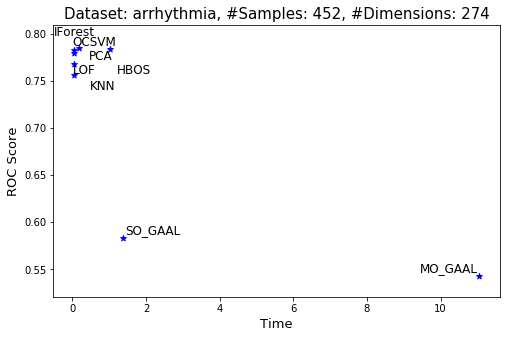

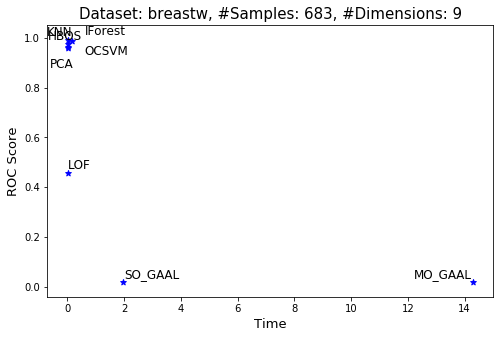

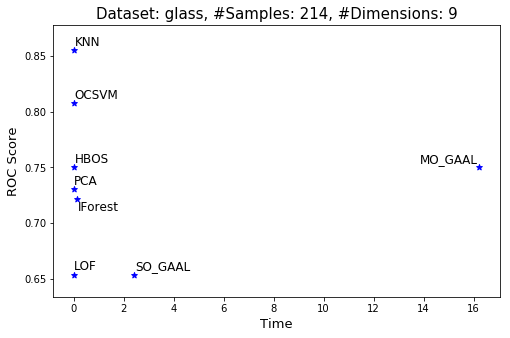

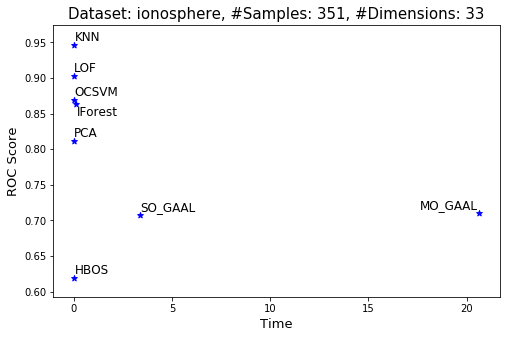

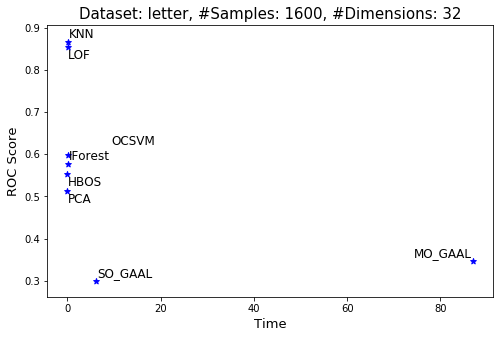

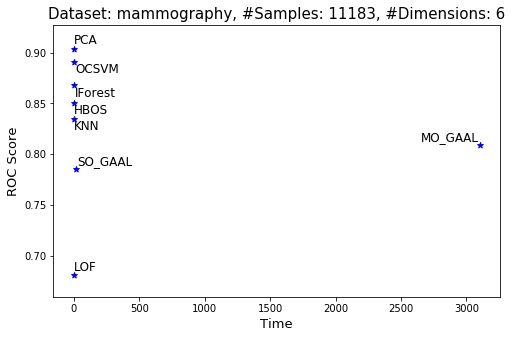

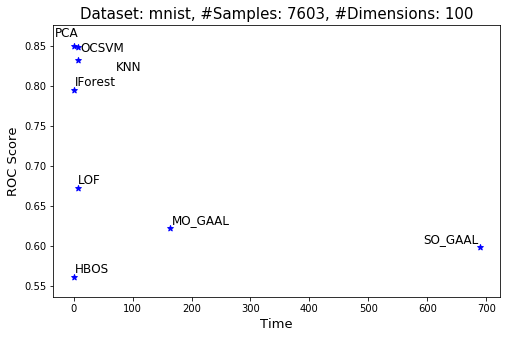

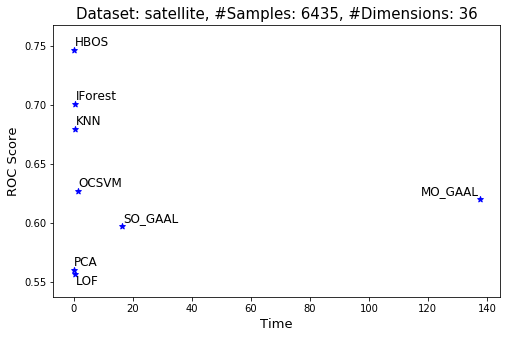

In [4]:
from adjustText import adjust_text

models = df_columns[4:]

# ROC vs Time
for mat_file in mat_file_list:
    data_title = mat_file[:-4]
    x = time_df[time_df['Dataset'] == data_title]
    y = roc_df[roc_df['Dataset'] == data_title]
    
    data_x = x[models].values[0]
    data_y = y[models].values[0]
    
    plt.figure(figsize=(8, 5))
    plt.title(
        "Dataset: {}, #Samples: {}, #Dimensions: {}".format(
            data_title,
            x[df_columns[1]][0],
            x[df_columns[2]][0]
        ),
        fontsize=15
    )
    plt.scatter(data_x, data_y, marker='*', color='blue')
    plt.xlabel("Time", fontsize=13)
    plt.ylabel("ROC Score", fontsize=13)
    texts = [plt.text(data_x[i], data_y[i], models[i], size=12) for i in range(len(models))]
    adjust_text(texts)
    plt.show()

In [6]:
mat_file = 'satellite.mat'
mat = loadmat(os.path.join('datasets', mat_file))

X = mat['X']
y = mat['y'].ravel()
outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)

In [16]:
# 75% data for training and 25% for testing. Default values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=random_state)

# standardizing data for processing, mean=0, var=1
X_train_norm, X_test_norm = standardizer(X_train, X_test)

classifiers = {
    'Angle-based Outlier Detector (ABOD)': ABOD(
        contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(contamination=outliers_fraction, check_estimator=False,
                                                random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                      random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

In [24]:
# 'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state)
# 'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction)

clf_name, clf = ['Isolation Forest',
                 IForest(contamination=outliers_fraction, random_state=random_state)]

clf.fit(X_train_norm)
test_scores = clf.decision_function( X_test_norm)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision @ rank n:{prn}'.format(clf_name=clf_name, roc=roc, prn=prn))

Isolation Forest ROC:0.7231, precision @ rank n:0.5717


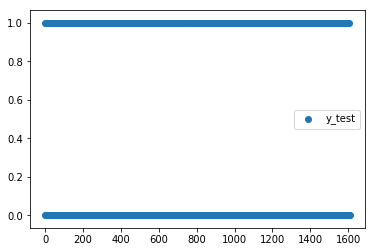

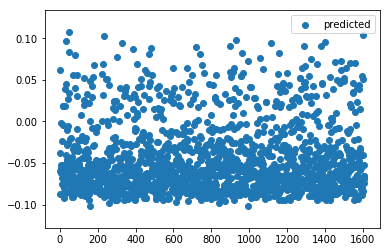

In [34]:
plt.scatter(range(len(y_test)), y_test, label='y_test')
# plt.scatter(range(len(test_scores)), test_scores, label='predicted')
plt.legend()
plt.show()

plt.scatter(range(len(test_scores)), test_scores, label='predicted')
plt.legend()
plt.show()

In [147]:
clf.stop_epochs

1000

In [3]:
from pyod.models.mo_gaal import MO_GAAL
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

contamination = 0.1  # percentage of outliers
n_train = 30000  # number of training points
n_test = 3000  # number of testing points
n_features = 2  # number of features

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=n_features,
                  contamination=contamination,
                  random_state=42)

clf_name = 'MO_GAAL'
clf = MO_GAAL(contamination=contamination, stop_epochs=2)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

Using TensorFlow backend.


Epoch 1 of 6

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:

Testing for epoch 1 index 6:

Testing for epoch 1 index 7:

Testing for epoch 1 index 8:

Testing for epoch 1 index 9:

Testing for epoch 1 index 10:

Testing for epoch 1 index 11:

Testing for epoch 1 index 12:

Testing for epoch 1 index 13:

Testing for epoch 1 index 14:

Testing for epoch 1 index 15:

Testing for epoch 1 index 16:

Testing for epoch 1 index 17:

Testing for epoch 1 index 18:

Testing for epoch 1 index 19:

Testing for epoch 1 index 20:

Testing for epoch 1 index 21:

Testing for epoch 1 index 22:

Testing for epoch 1 index 23:

Testing for epoch 1 index 24:

Testing for epoch 1 index 25:

Testing for epoch 1 index 26:

Testing for epoch 1 index 27:

Testing for epoch 1 index 28:

Testing for epoch 1 index 29:

Testing for epoch 1 index 30:

Testing for epoch 1 index 31:

Testing for epoch 1 index 32:

Tes

500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 10:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 11:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 12:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 13:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 14:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 15:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 16:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 17:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 18:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 19:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 20:
500/500 [==============================] - 0s

500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 24:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 25:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 26:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 27:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 28:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 29:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 30:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 31:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 32:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 33:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 34:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 38:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 39:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 40:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 41:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 42:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 43:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 44:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 45:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 46:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 47:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 48:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 52:
500/500 [==============================] - 0s 9us/step

Testing for epoch 3 index 53:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 54:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 55:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 56:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 57:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 58:
500/500 [==============================] - 0s 10us/step

Testing for epoch 3 index 59:
500/500 [==============================] - 0s 11us/step

Testing for epoch 3 index 60:
500/500 [==============================] - 0s 10us/step
Epoch 4 of 6

Testing for epoch 4 index 1:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 2:
500/500 [=========================

500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 6:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 7:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 8:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 9:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 10:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 11:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 12:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 13:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 14:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 15:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 16:
500/500 [==============================] - 0s 11

500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 19:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 20:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 21:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 22:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 23:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 24:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 25:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 26:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 27:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 28:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 29:
500/500 [==============================] - 0s

500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 33:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 34:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 35:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 36:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 37:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 38:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 39:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 40:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 41:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 42:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 43:
500/500 [==============================] - 0

500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 47:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 48:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 49:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 50:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 51:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 52:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 53:
500/500 [==============================] - 0s 9us/step

Testing for epoch 4 index 54:
500/500 [==============================] - 0s 11us/step

Testing for epoch 4 index 55:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 56:
500/500 [==============================] - 0s 10us/step

Testing for epoch 4 index 57:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 10us/step
Epoch 5 of 6

Testing for epoch 5 index 1:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 2:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 3:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 4:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 5:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 6:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 7:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 8:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 9:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 10:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 11:
500/500 [==============================] 

500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 15:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 16:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 17:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 18:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 19:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 20:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 21:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 22:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 23:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 24:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 25:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 29:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 30:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 31:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 32:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 33:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 34:
500/500 [==============================] - 0s 12us/step

Testing for epoch 5 index 35:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 36:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 37:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 38:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 39:
500/500 [==============================] - 0s

500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 43:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 44:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 45:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 46:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 47:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 48:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 49:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 50:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 51:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 52:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 53:
500/500 [==============================] - 0

500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 57:
500/500 [==============================] - 0s 11us/step

Testing for epoch 5 index 58:
500/500 [==============================] - 0s 10us/step

Testing for epoch 5 index 59:
500/500 [==============================] - 0s 9us/step

Testing for epoch 5 index 60:
500/500 [==============================] - 0s 10us/step
Epoch 6 of 6

Testing for epoch 6 index 1:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 2:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 3:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 4:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 5:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 6:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 7:
500/500 [==============================

500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 10:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 11:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 12:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 13:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 14:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 15:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 16:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 17:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 18:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 19:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 20:
500/500 [==============================] - 0s 1

500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 24:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 25:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 26:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 27:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 28:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 29:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 30:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 31:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 32:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 33:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 34:
500/500 [==============================] - 0

500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 38:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 39:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 40:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 41:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 42:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 43:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 44:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 45:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 46:
500/500 [==============================] - 0s 12us/step

Testing for epoch 6 index 47:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 48:
500/500 [==============================] - 0s 

500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 52:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 53:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 54:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 55:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 56:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 57:
500/500 [==============================] - 0s 9us/step

Testing for epoch 6 index 58:
500/500 [==============================] - 0s 10us/step

Testing for epoch 6 index 59:
500/500 [==============================] - 0s 11us/step

Testing for epoch 6 index 60:
500/500 [==============================] - 0s 11us/step

On Training Data:
MO_GAAL ROC:0.5459, precision @ rank n:0.5233

On Test Data:
MO_GAAL ROC:0.5069, precision @ rank n:0.4324


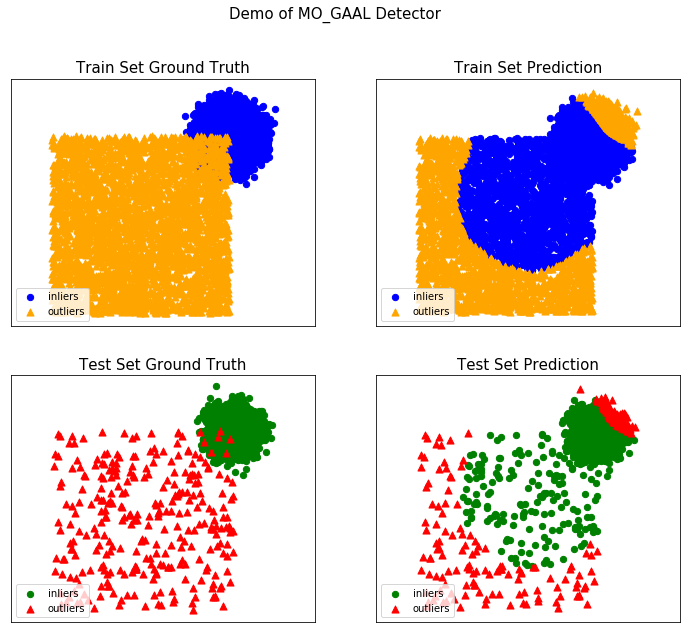

In [4]:
from pyod.utils.example import visualize

# visualize(clf_name,
#           X_train[:, :2], y_train,
#           X_test[:, :2], y_test,
#           y_train_pred, y_test_pred,
#           show_figure=True, save_figure=False)

visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [119]:
from pyod.models.so_gaal import SO_GAAL
from pyod.utils.data import evaluate_print, generate_data

X_train, y_train, X_test, y_test = generate_data(n_train=200, n_test=100,
                                                 n_features=2, contamination=0.2)

clf_name = 'SO_GAAL'
clf = SO_GAAL()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

Epoch 1 of 60

Testing for epoch 1 index 1:

On Training Data:
SO_GAAL ROC:0.1872, precision @ rank n:0.15

On Test Data:
SO_GAAL ROC:0.1488, precision @ rank n:0.05


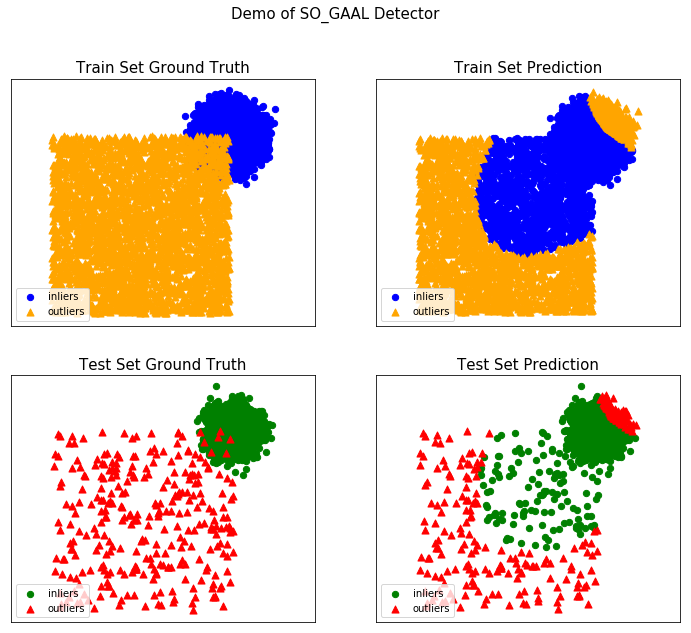

In [11]:
from pyod.utils.example import visualize

visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [ ]:
plt.figure(figsize=(15, 12))

scores_pred = clf.decision_function(X) * -1
y_pred = clf.predict(X)
threshold = percentile(scores_pred, 100 * outliers_fraction)
n_errors = (y_pred != ground_truth).sum()
# plot the levels lines and the points

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
subplot = plt.subplot(3, 4, i + 1)
subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                 cmap=plt.cm.Blues_r)
a = subplot.contour(xx, yy, Z, levels=[threshold],
                    linewidths=2, colors='red')
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                 colors='orange')
b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                    s=20, edgecolor='k')
c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                    s=20, edgecolor='k')
subplot.axis('tight')
subplot.legend(
    [a.collections[0], b, c],
    ['learned decision function', 'true inliers', 'true outliers'],
    prop=matplotlib.font_manager.FontProperties(size=10),
    loc='lower right')
subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
subplot.set_xlim((-7, 7))
subplot.set_ylim((-7, 7))

plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")
plt.show()

In [113]:
from pyod.models.knn import KNN   # kNN detector
from pyod.utils.data import evaluate_print, generate_data

X_train, y_train, X_test, y_test = generate_data(n_train=200, n_test=100,
                                                 n_features=2, contamination=0.2)

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.8839, precision @ rank n:0.7

On Test Data:
KNN ROC:0.9438, precision @ rank n:0.8


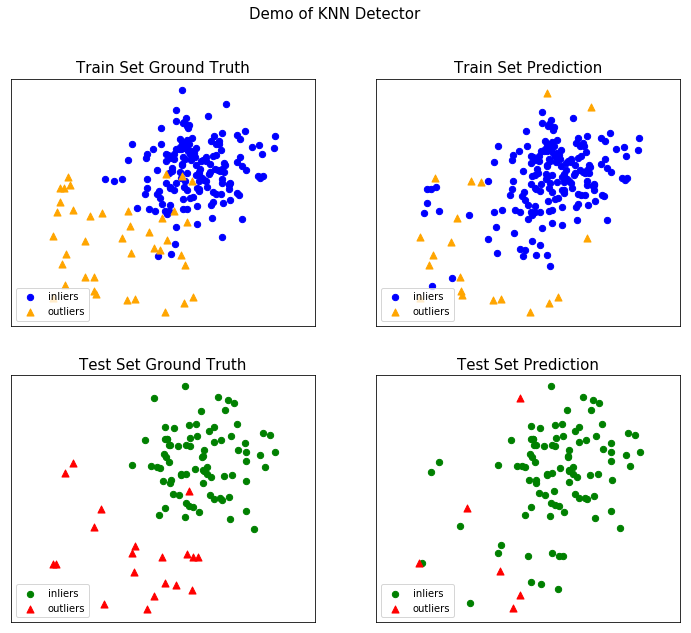

In [115]:
from pyod.utils.example import visualize

visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [79]:
X_train_norm, X_test_norm = standardizer(X_train, X_test)

In [80]:
clf_name, clf = ['Isolation Forest',
                 IForest(contamination=outliers_fraction, random_state=random_state)]

clf.fit(X_train_norm)
test_scores = clf.decision_function(X_test_norm)

roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

print('{clf_name} ROC:{roc}, precision @ rank n:{prn}'.format(clf_name=clf_name, roc=roc, prn=prn))

Isolation Forest ROC:0.9733, precision @ rank n:0.7


In [98]:
clf.predict(X_test_norm[:10])

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [96]:
clf.predict_proba(X_test_norm[:10], method='unify')

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.89086876, 0.10913124],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.45691057, 0.54308943],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [81]:
clf.predict_proba(X_test_norm)

array([[0.9533114 , 0.0466886 ],
       [0.86425022, 0.13574978],
       [0.75418067, 0.24581933],
       [0.86354695, 0.13645305],
       [0.8570558 , 0.1429442 ],
       [0.87415439, 0.12584561],
       [0.94814323, 0.05185677],
       [0.6164816 , 0.3835184 ],
       [0.91709132, 0.08290868],
       [0.94487256, 0.05512744],
       [0.86511712, 0.13488288],
       [0.50731664, 0.49268336],
       [0.76362364, 0.23637636],
       [0.8205121 , 0.1794879 ],
       [0.93906991, 0.06093009],
       [0.91967204, 0.08032796],
       [0.82628898, 0.17371102],
       [0.88156937, 0.11843063],
       [0.89010898, 0.10989102],
       [0.89987263, 0.10012737],
       [0.96734497, 0.03265503],
       [0.95092351, 0.04907649],
       [0.91762442, 0.08237558],
       [0.93509042, 0.06490958],
       [0.91449328, 0.08550672],
       [0.26309336, 0.73690664],
       [0.66281329, 0.33718671],
       [0.91012464, 0.08987536],
       [0.93863431, 0.06136569],
       [0.92327983, 0.07672017],
       [0.

In [ ]:
roc_auc_score(y_true, y_scores)

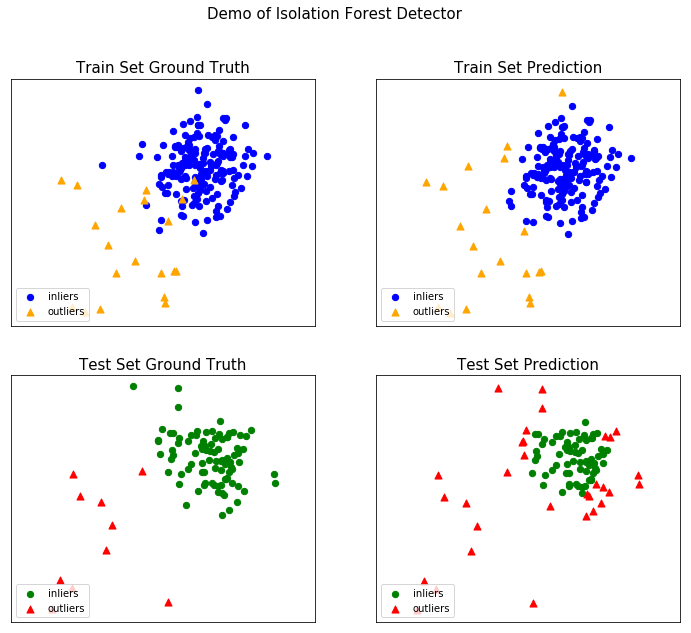

In [75]:
y_test_pred = clf.predict(X_test_norm)  # outlier labels (0 or 1)
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

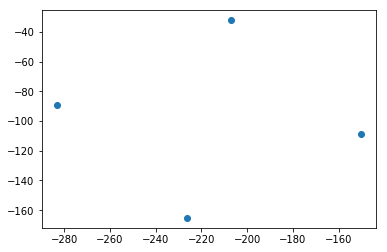

In [12]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [40]:
roc_df

,Dataset,#Samples,#Dimensions,%Outliers,KNN,PCA,OCSVM,LOF,HBOS,IForest,SO_GAAL,MO_GAAL
0,arrhythmia,452,274,14.6018,0.7555,0.7794,0.7825,0.7672,0.7831,0.7849,0.5827,0.5429
0,breastw,683,9,34.9927,0.9908,0.9608,0.9649,0.4574,0.9764,0.9872,0.0186,0.0191
0,glass,214,9,4.2056,0.8558,0.7308,0.8077,0.6538,0.75,0.7212,0.6538,0.75
0,ionosphere,351,33,35.8974,0.946,0.8115,0.8684,0.9023,0.619,0.8632,0.7069,0.7103
0,letter,1600,32,6.25,0.866,0.5119,0.5985,0.853,0.5532,0.577,0.3004,0.3465
0,mammography,11183,6,2.325,0.8346,0.9039,0.8911,0.6806,0.8506,0.868,0.7852,0.8085
0,mnist,7603,100,9.2069,0.8322,0.8493,0.8487,0.6727,0.5607,0.7942,0.5981,0.6223
0,satellite,6435,36,31.6395,0.6795,0.5601,0.6274,0.5567,0.7464,0.7008,0.5975,0.6201


In [102]:
# import numpy as np
# from sklearn.manifold import TSNE
# from pyod.utils.data import get_outliers_inliers
# import tqdm

# after_tsne = dict()

# for mat_file in tqdm.tqdm(mat_file_list):
#     mat = loadmat(os.path.join('datasets', 'odds', mat_file))

#     X = mat['X']
#     y = mat['y'].ravel()

#     X_embedded = TSNE(n_components=2).fit_transform(X)

#     X_out, X_in = get_outliers_inliers(X_embedded, y)
#     after_tsne[mat_file] = (X_out, X_in)

100%|██████████| 8/8 [02:47<00:00, 32.69s/it]


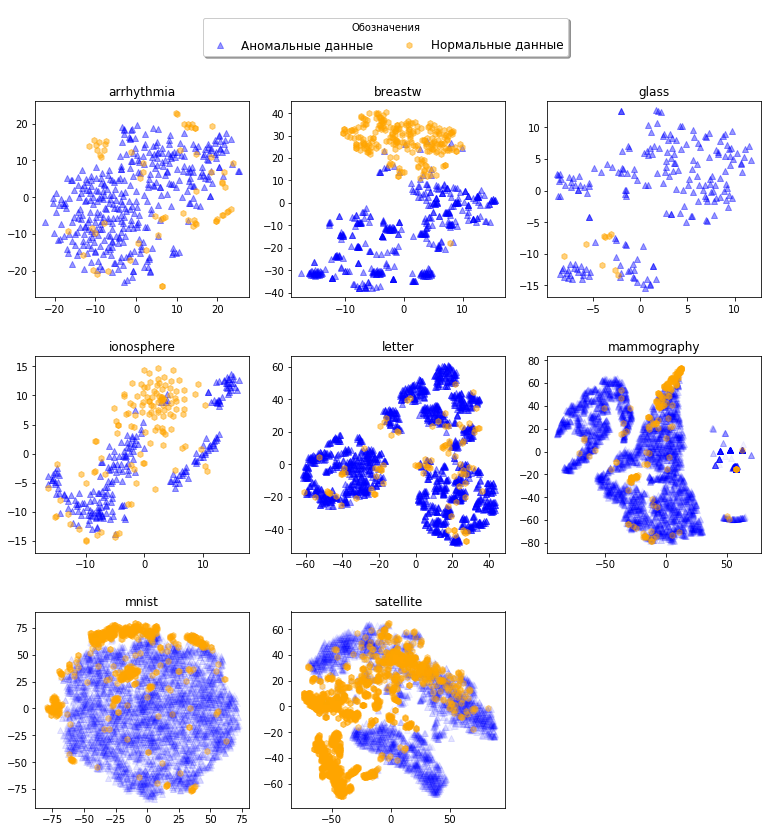

In [154]:
fig = plt.figure(figsize=(13, 13))
for i, mat_file in enumerate(mat_file_list):
    fig.add_subplot("33{}".format(i + 1))
    X_out, X_in = after_tsne[mat_file]
    if i > 4:
        plt.scatter(X_in[:, 0], X_in[:, 1], color='blue', marker='^', alpha=0.05)
        plt.scatter(X_out[:, 0], X_out[:, 1], color='orange', marker='h', alpha=0.4)
    else:
        plt.scatter(X_in[:, 0], X_in[:, 1], color='blue', marker='^', alpha=0.4)
        plt.scatter(X_out[:, 0], X_out[:, 1], color='orange', marker='h', alpha=0.5)
    plt.title(mat_file[:-4])
fig.legend(labels=['Аномальные данные', 'Нормальные данные'],
           loc=9, borderaxespad=1.5, title="Обозначения", shadow=True, ncol=3, fontsize=12)
plt.subplots_adjust(hspace=0.3)
# plt.show()
plt.savefig('images/2d_comparison.png', dpi=100)